# Deep Learning final project:  DeepRedshift 🤖

*By: Gabriel Missael Barco*

*Professor: Dra. Alma Xochitl González Morales*

The objective of this project is, given the light from a quasar, to predict its redshift. The redshift is an essential parameter in cosmology.

The data is taken from a simulation provided by the professor and it's composed of 40,000 quasars. An example of the data is shown below:

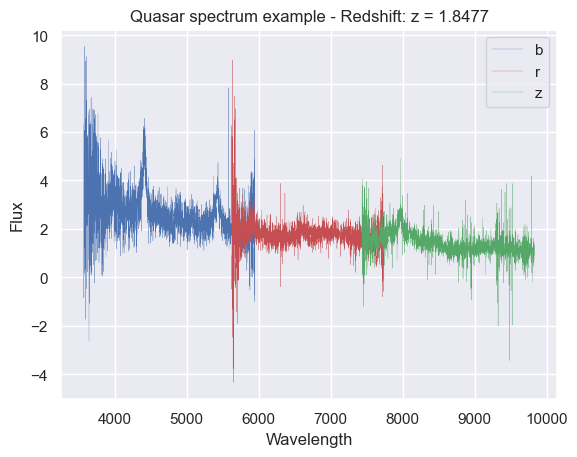

In [67]:
from IPython.display import Image
Image(filename='images/data-example.png', width=400)

To assess this problem, we tried two different approaches:
1. Fully connected neural networks.
2. Convolutional neural networks.

For each of those approaches, we tried different architectures and hyperparameters. We ran **77 different experiments**. We obtained the best results with (surprisingly) a fully connected neural network. The summary of the best result is shown below:

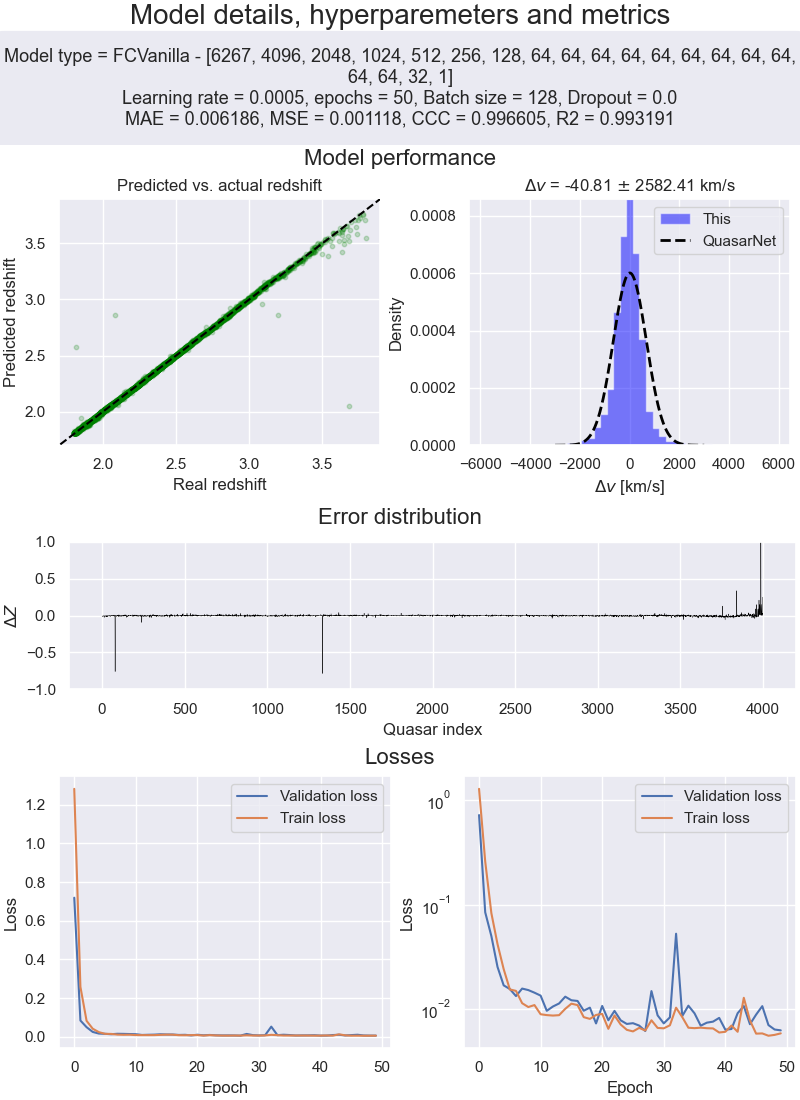

In [68]:
Image(filename='images/best_run.png', width=400)

To compare this result, we compare this best run with the results obtained by [Niculas Busca, Christophe Ballan, 2018, _QuasarNET: Human-level spectral classification and redshifting with Deep Neural Networks_ ](https://arxiv.org/abs/1808.09955). Notably, we compare the distribution of the implied velocity difference between the predicted and the real redshift. In summary, this model is **five times worse than QuasarNET in predicting the redshift**.

QuasarNET obtains a $\Delta v = (8 \pm 664)km/s$, and this project $\Delta v = (-40 \pm 2582)km/s$. The difference is huge, but it's important to remember that this model was trained with only 40k examples, while QuasarNET was trained with about half a million examples.

#### Weights & biases magic ✨

We tracked all of the experiments with [Weights and Biases](https://www.wandb.com/). This tool is handy for keeping track of the experiments. The link to the project is here: [https://wandb.ai/gmissaelbarco/QuasarNN?workspace=user-gmissaelbarco](https://wandb.ai/gmissaelbarco/QuasarNN?workspace=user-gmissaelbarco). You can see the experiments' results, the code, and the hyperparameters used.

#### How to run the code 🏃‍♂️

All the code is available in the GitHub repository: [https://github.com/GabrielMissael/QuasarNN](https://github.com/GabrielMissael/QuasarNN). To copy the repository, run:

```bash
git clone https://github.com/GabrielMissael/QuasarNN.git
cd QuasarNN
```

To run the code, you need to have [Python 3.9](https://www.python.org/downloads/) and [conda](https://docs.conda.io/en/latest/miniconda.html) installed. Then, you need to create a new environment with the dependencies:

```bash
conda create -n quasar python=3.8
conda activate quasar
conda install --file requirements.txt
```

Then, you can start running the main notebook, and that's it! 🎉. There are two notebooks, this one with all the project details and code explained, and the other one with the code only, `proyecto_final.ipynb`. Part of the code used in the `proyecto_final.ipynb` notebook is in the `DeepRedshift` folder.

Finally, if you prefer to read the report, refer to the `final_report.pdf` file, which was generated with this notebook and Pandoc. Thanks for reading! 🙏

#### References 📚

- [Niculas Busca, Christophe Ballan, 2018, _QuasarNET: Human-level spectral classification and redshifting with Deep Neural Networks_ ](https://arxiv.org/abs/1808.09955)

## Imports 📖

First of all, we import the necessary libraries. We use PyTorch for the neural networks, and other standard libraries for data manipulation and visualization such as Pandas, Numpy, and Matplotlib.

In [54]:
import glob # For reading files
from astropy.io import fits # For reading fits files
import numpy as np # For array operations
import pandas as pd # For dataframes
import matplotlib.pyplot as plt # For plotting
import matplotlib as mpl # For plotting
import seaborn as sns # For plotting
from tqdm import tqdm # For progress bars
import os # For reading paths
import logging # For logging
import wandb # To keep track of experiments
import scipy.stats as stats # For statistical tests

# Pytroch modules for neural networks
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, optim
from torchinfo import summary
from torchmetrics import (
    MeanAbsoluteError,
    MeanSquaredError,
    ConcordanceCorrCoef,
    PearsonCorrCoef,
    R2Score)

# Show selected GPU
gpu_idx = torch.cuda.current_device()
print(torch.cuda.get_device_properties(gpu_idx))

# Read the wavelength array (same for all spectra)
wv = pd.read_csv('data/QSOs/0.csv')['wave'].values

# For reproducibility
torch.manual_seed(42)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Wandb config
os.environ["WANDB_SILENT"] = "true"

# Figure style
sns.set_theme()

# Figure dpi
mpl.rcParams['figure.dpi'] = 300

# Logger
logger = logging.getLogger('wandb')
logger.setLevel(logging.ERROR)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3060 Laptop GPU', major=8, minor=6, total_memory=6143MB, multi_processor_count=30)


## Optimizing metrics 📈

Basically, we hava a regression problem, and we need to choose a metric to optimize. For this project, we decided to use the mean absolute error (MAE) as the metric to optimize. This metric is the average of the absolute value of the errors. It's a good metric for this problem because it's not sensitive to outliers. We also use the mean squared error (MSE) as a metric to compare the results.

Besides this, we also keep track of the following metrics:
1. Concordance correlation coefficient (CCC).
2. R2 score.
3. Mean Squared Error (MSE).

In [56]:
metrics = {
    'mae': MeanAbsoluteError(),
    'mse': MeanSquaredError(),
    'ccc': ConcordanceCorrCoef(num_outputs=1),
    'r2': R2Score()
}

## Pre-process data ⚙️

Before start working on the neural networks, we need to pre-process the data. The data is composed of 40,000 quasar spectrums, with three bands: $u$, $g$, and $r$. Each band corresponds to different wavelength intervals. Let's take a look at the data:

In [3]:
# Read all the data
df = pd.read_pickle('data/data.pkl')

The QSO simulations contains a lot of information, but we only selected the information shown below.

In [4]:
# Show dataframe structure
df.head(3)

,flux_full,Z,flux_b,wave_b,flux_r,wave_r,flux_z,wave_z
50130291,5.5749,1.847688,"[6.316943645477295, 4.637505054473877, 4.45759...","[3569.39990234375, 3570.39990234375, 3571.3999...","[0.8951932787895203, -0.48711779713630676, 6.2...","[5625.39990234375, 5626.39990234375, 5627.3999...","[1.343870759010315, 2.467992067337036, 4.08662...","[7435.39990234375, 7436.39990234375, 7437.3999..."
50130304,4.427626,1.817459,"[3.4335825443267822, 1.9359098672866821, 3.305...","[3569.39990234375, 3570.39990234375, 3571.3999...","[-1.2831424474716187, -0.7486328482627869, 0.2...","[5625.39990234375, 5626.39990234375, 5627.3999...","[0.5637927651405334, 1.4473059177398682, 2.588...","[7435.39990234375, 7436.39990234375, 7437.3999..."
50130318,4.652752,1.940764,"[22.567916870117188, 24.14146614074707, 19.105...","[3569.39990234375, 3570.39990234375, 3571.3999...","[0.07029576599597931, -7.117312908172607, -3.0...","[5625.39990234375, 5626.39990234375, 5627.3999...","[2.164449691772461, 0.7670164704322815, -1.800...","[7435.39990234375, 7436.39990234375, 7437.3999..."


We are interested in predicting the redshift $z$. Here is the distribution of that variable:

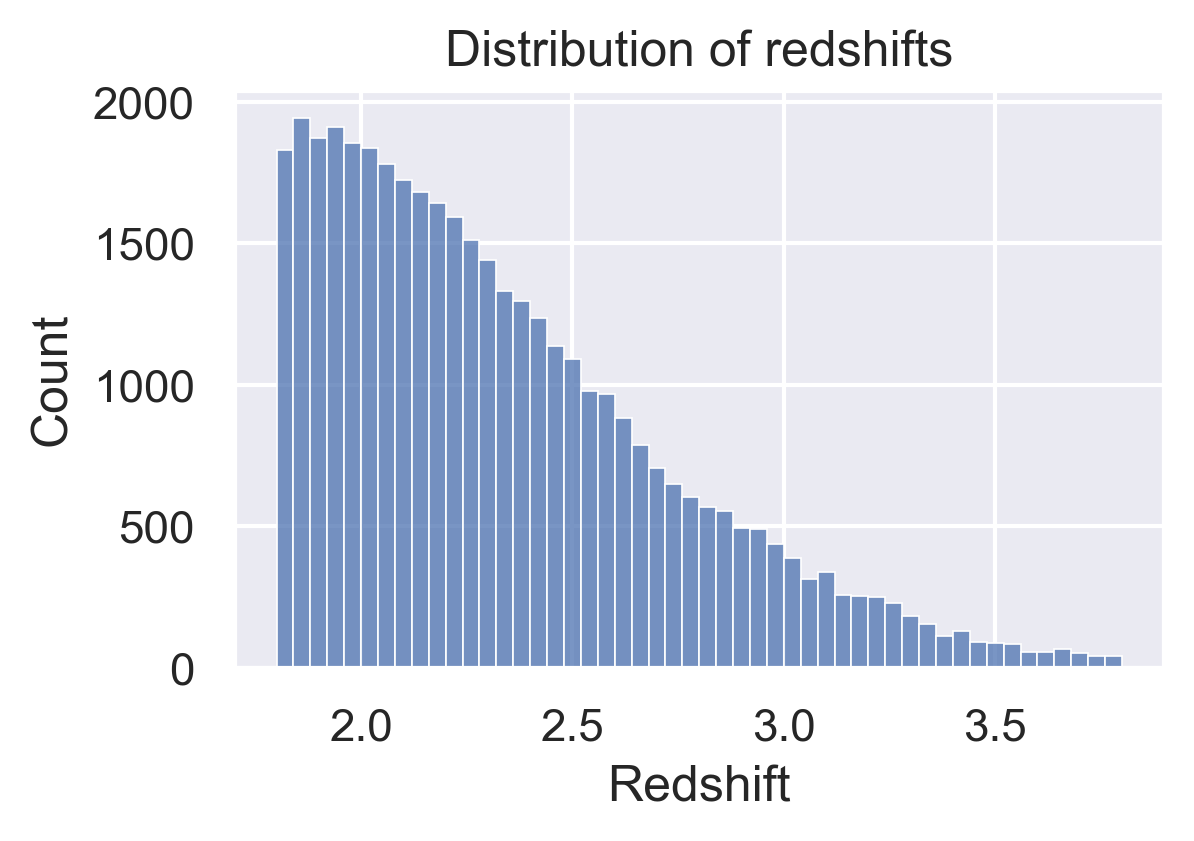

Min redshift: 1.800
Max redshift: 3.800
Mean redshift: 2.337
Std redshift: 0.406


In [8]:
# Distribution of redshifts
fig, ax = plt.subplots(1, 1, figsize=(4, 2.5))
sns.histplot(df['Z'], ax=ax, bins=50)
ax.set_xlabel('Redshift')
ax.set_ylabel('Count')
ax.set_title('Distribution of redshifts')
plt.show()

# Print range of redshifts
print('Min redshift: {:.3f}'.format(df['Z'].min()))
print('Max redshift: {:.3f}'.format(df['Z'].max()))

# Mean and standard deviation of redshifts
print('Mean redshift: {:.3f}'.format(df['Z'].mean()))
print('Std redshift: {:.3f}'.format(df['Z'].std()))

An example of the data is shown below:

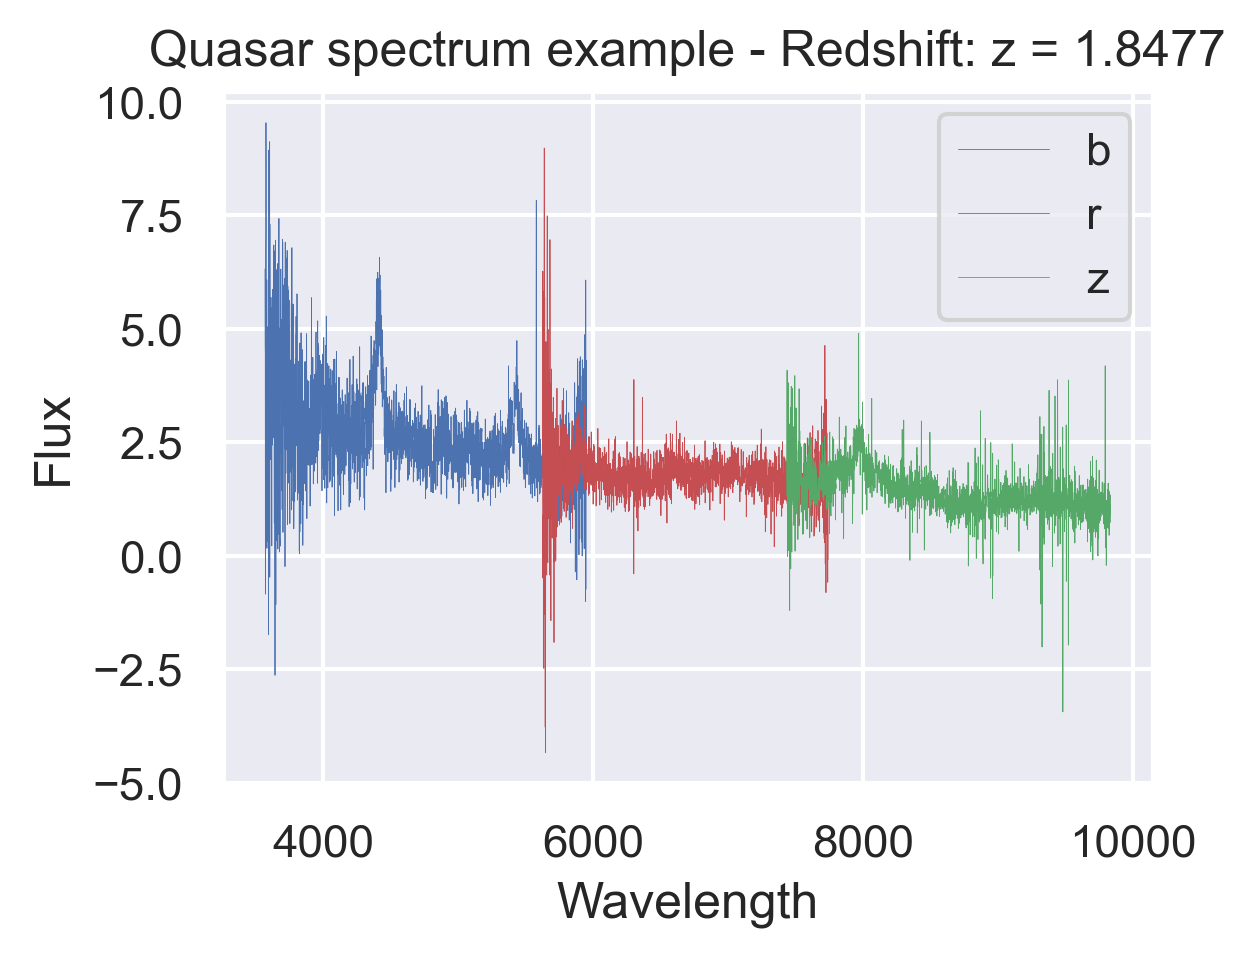

In [9]:
# Create figure
fig = plt.figure(figsize=(4, 3))

# Select one quasar
df_row = df.iloc[0]

# Extract data
flux_b = df_row['flux_b']
wave_b = df_row['wave_b']
flux_r = df_row['flux_r']
wave_r = df_row['wave_r']
flux_z = df_row['flux_z']
wave_z = df_row['wave_z']
z = df_row['Z']

# Generate plot
plt.plot(wave_b, flux_b, color = 'b', linewidth = 0.2, label = 'b')
plt.plot(wave_r, flux_r, color = 'r', linewidth = 0.2, label = 'r')
plt.plot(wave_z, flux_z, color = 'g', linewidth = 0.2, label = 'z')
plt.legend()
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title(f'Quasar spectrum example - Redshift: z = {z:.4f}')
plt.show()

We could try to work with the three bands as they are, but we decided to merge them into a single band, and preserve the sequiential information they have. To do this, we simple choose the middle point between two consecutive bands. An example of this process is shown below:

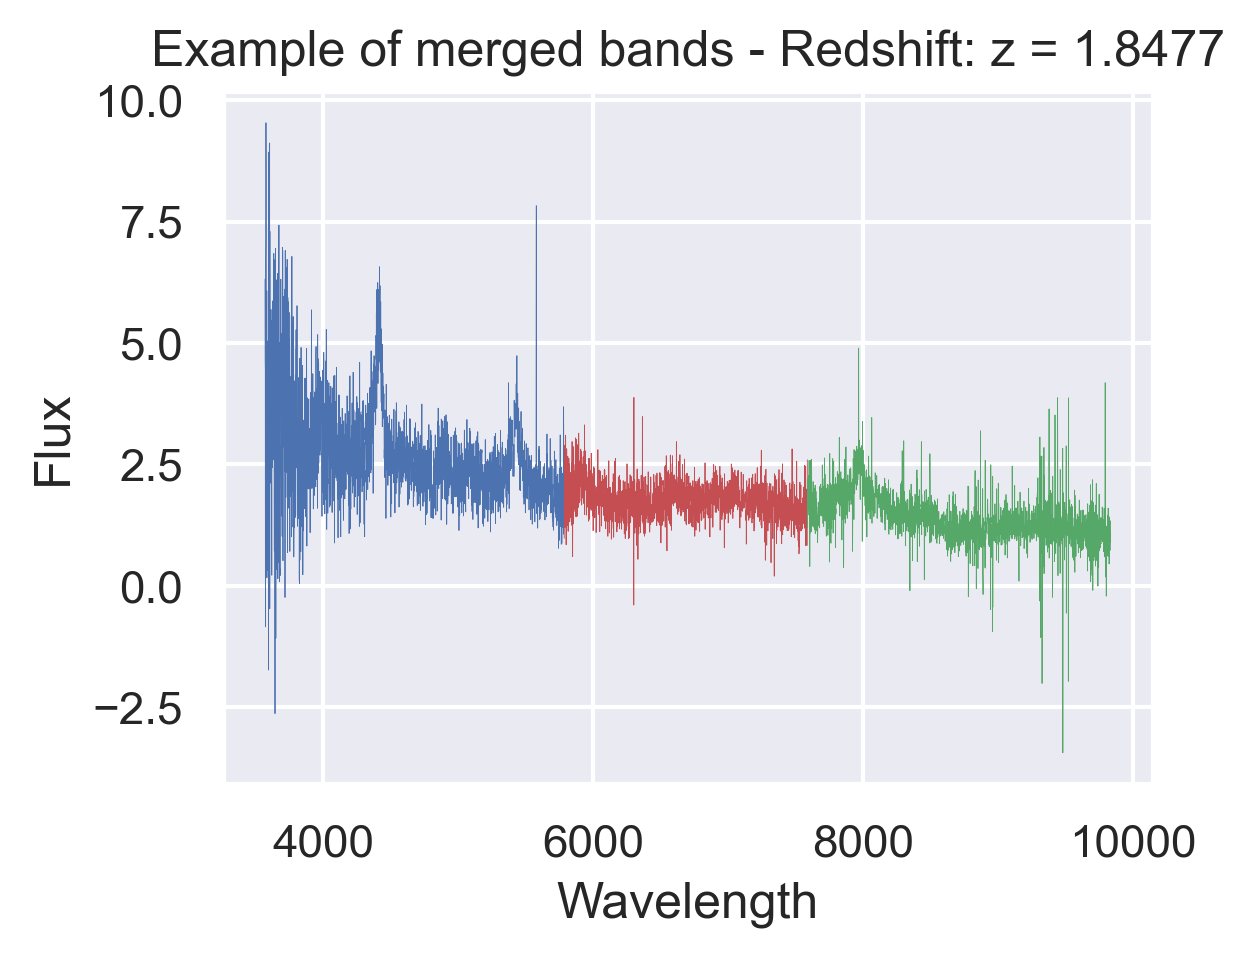

In [10]:
# Create figure
fig = plt.figure(figsize=(4, 3))

# Middle points of the wavelength ranges
delta_br = (wave_b[-1] + wave_r[0]) / 2
delta_rz = (wave_r[-1] + wave_z[0]) / 2

# New flux and wavelength arrays
flux_b = flux_b[:np.where(delta_br < wave_b)[0][0]]
wave_b = wave_b[:np.where(delta_br < wave_b)[0][0]]
flux_r = flux_r[np.where(delta_br > wave_r)[0][-1]:np.where(delta_rz < wave_r)[0][0]]
wave_r = wave_r[np.where(delta_br > wave_r)[0][-1]:np.where(delta_rz < wave_r)[0][0]]
flux_z = flux_z[np.where(delta_rz > wave_z)[0][-1]:]
wave_z = wave_z[np.where(delta_rz > wave_z)[0][-1]:]

# Plot result
plt.plot(wave_b, flux_b, color = 'b', linewidth = 0.2)
plt.plot(wave_r, flux_r, color = 'r', linewidth = 0.2)
plt.plot(wave_z, flux_z, color = 'g', linewidth = 0.2)
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title(f'Example of merged bands - Redshift: z = {z:.4f}')
plt.show()

And finally, once we concatenate the three bands, we have only one array of sequential data for each spectrum.

(6267,)


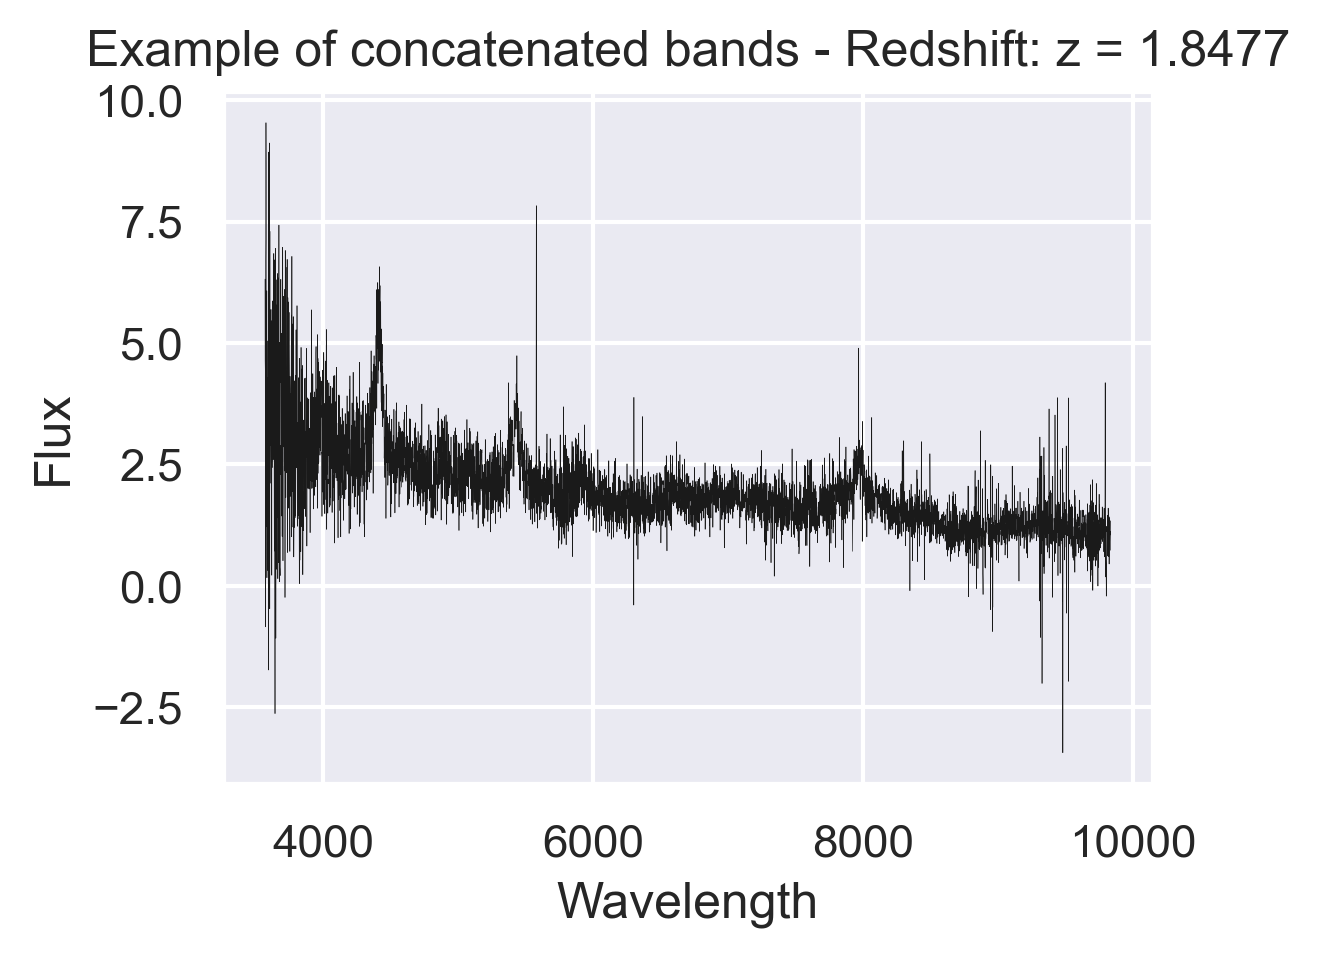

In [11]:
# Create figure
fig = plt.figure(figsize=(4, 3))

# Concatenate
flux = np.concatenate((flux_b, flux_r, flux_z))
wave = np.concatenate((wave_b, wave_r, wave_z))

plt.plot(wave, flux, color = 'k', linewidth = 0.15)
print(flux.shape)
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title(f'Example of concatenated bands - Redshift: z = {z:.4f}')
plt.show()

As we can see, each spectra has 6267 wavelenth bins. Finally, we do this process for all the spectra and save the result in a new file.

In [12]:
# Create lists to store data
Z = []
ids = []
flux_full = []
flux = []
wv = []

# Iterate over all the rows
for i in tqdm(range(0, len(df))):
    # Get i-th row
    df_row = df.iloc[i]

    # Extract data
    flux_b = df_row['flux_b']
    wave_b = df_row['wave_b']
    flux_r = df_row['flux_r']
    wave_r = df_row['wave_r']
    flux_z = df_row['flux_z']
    wave_z = df_row['wave_z']
    Z.append(df_row['Z'])
    ids.append(df_row.name)
    flux_full.append(df_row['flux_full'])

    # Middle points of the wavelength ranges
    delta_br = (wave_b[-1] + wave_r[0]) / 2
    delta_rz = (wave_r[-1] + wave_z[0]) / 2

    # New flux and wavelength arrays
    flux_b = flux_b[:np.where(delta_br < wave_b)[0][0]]
    wave_b = wave_b[:np.where(delta_br < wave_b)[0][0]]
    flux_r = flux_r[np.where(delta_br > wave_r)[0][-1]:np.where(delta_rz < wave_r)[0][0]]
    wave_r = wave_r[np.where(delta_br > wave_r)[0][-1]:np.where(delta_rz < wave_r)[0][0]]
    flux_z = flux_z[np.where(delta_rz > wave_z)[0][-1]:]
    wave_z = wave_z[np.where(delta_rz > wave_z)[0][-1]:]

    # Concatenate
    flux_i = np.concatenate((flux_b, flux_r, flux_z))
    wave_i = np.concatenate((wave_b, wave_r, wave_z))

    # Append to lists
    flux.append(flux_i)
    wv.append(wave_i)

100%|██████████| 40000/40000 [00:26<00:00, 1526.31it/s]


In [13]:
# Create new dataframe with processed data
data = {'id': ids, 'Z': Z, 'flux_full': flux_full, 'flux': flux, 'wave': wv}
df = pd.DataFrame(data)
df.head()

,id,Z,flux_full,flux,wave
0,50130291,1.847688,5.574900,"[6.316943645477295, 4.637505054473877, 4.45759...","[3569.39990234375, 3570.39990234375, 3571.3999..."
1,50130304,1.817459,4.427626,"[3.4335825443267822, 1.9359098672866821, 3.305...","[3569.39990234375, 3570.39990234375, 3571.3999..."
2,50130318,1.940764,4.652752,"[22.567916870117188, 24.14146614074707, 19.105...","[3569.39990234375, 3570.39990234375, 3571.3999..."
3,50130322,2.279219,4.309511,"[3.3110246658325195, 1.6816339492797852, 9.821...","[3569.39990234375, 3570.39990234375, 3571.3999..."
4,50130325,2.290676,12.221321,"[1.4321434497833252, 13.602473258972168, 2.557...","[3569.39990234375, 3570.39990234375, 3571.3999..."


In [14]:
# If data is not saved, save it
if not os.path.exists('data/data_ready.pkl'):
    df.to_pickle('data/data_ready.pkl')

## Resample the data 🤔

Each quasar has a lot of wavelength bins. Furthermore, high variation in the flux in each bin can reduce performance and affect training. Because of this, we decided to create a second dataset with a lower resolution. We resample the data to about 500 bins. For that, we created the next function:

In [15]:
def rebin_data (wv, fluxes, bin_size = None):
    """Rebin data to a new bin size.

    Parameters
    ----------
    wv : array
        Wavelength array.
    fluxes : array
        Flux array.
    bin_size : float, optional
        New bin size. If None, the original bin size is used.

    Returns
    -------
    wv : array
        New wavelength array.
    fluxes : array
        New flux array.
    """

    # Change bin size
    new_bin_size = bin_size

    # Original bin size with one decimal place
    original_bin_size = wv[1] - wv[0]
    original_bin_size = round(original_bin_size, 1)

    # Number of bins to average over
    stack_number = new_bin_size / original_bin_size

    # Check if the number of bins to average over is an integer
    if abs(stack_number - round(stack_number)) > 0.00001:
        raise ValueError(f'New bin size {new_bin_size} must be a'\
            +f' multiple of the original bin size {original_bin_size:.3f}')

    # Ceil to first integer
    stack_number = int(round(stack_number))

    # New wavelength array
    wv = np.arange(wv[0], wv[-1] + bin_size, bin_size)

    # Remove extra bins from the fluxes
    remove = len(fluxes[0]) % stack_number
    if remove != 0:
        fluxes = fluxes[:, :-remove]

    # Reshape the flux array
    fluxes = fluxes.reshape(len(fluxes), -1, stack_number)

    # Average over the last axis
    fluxes = np.mean(fluxes, axis=-1)

    # Make wv and fluxes the same shape
    n_bins = len(fluxes[0])
    wv = wv[:n_bins]

    return wv, fluxes

Here is an example of a resampled spectrum:

Current bin size: 1.000
Current data shape: (6267,)
New bin size: 8.000
New data shape: (783,)


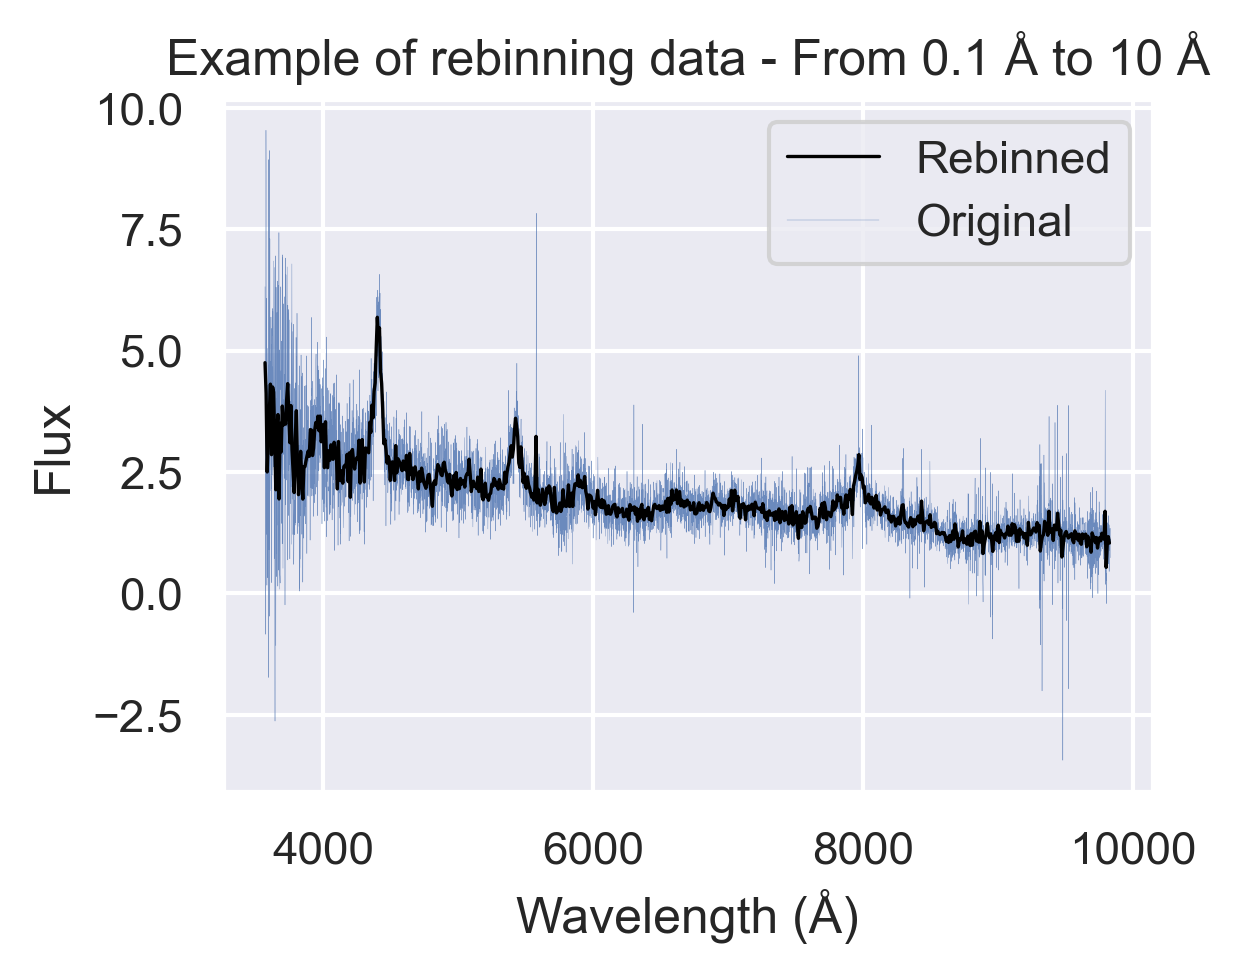

In [16]:
# Create figure
fig = plt.figure(figsize=(4, 3))

# Print current bin size and data shape
print(f'Current bin size: {wv[0][1] - wv[0][0]:.3f}')
print(f'Current data shape: {flux[0].shape}')

# New bin size
new_bin_size = 8.0

# Rebin data
wv_example, flux_example = rebin_data(wv[0], np.array([flux[0]]),
                                    bin_size = new_bin_size)

# Print new bin size and data shape
print(f'New bin size: {wv_example[1] - wv_example[0]:.3f}')
print(f'New data shape: {flux_example[0].shape}')

# Plot new data and old data
plt.plot(wv_example, flux_example[0], linewidth = 0.8, zorder = 5, 
        label = 'Rebinned', color = 'black')
plt.plot(wv[0], flux[0], linewidth = 0.1, alpha = 0.8, label = 'Original')
plt.legend()
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.title('Example of rebinning data - From 0.1 Å to 10 Å')
plt.show()

It can be seen that the resolution is lower, but the important information is preserved (such as the peaks). Now, we create our second dataset with the resampled data.

In [17]:
# Rebinn all data

# if dont exist, create
if not os.path.exists('data/data_rebinned.pkl'):
    # Copy dataframe
    df_rebinned = df.copy()

    # Apply rebinning function
    df_rebinned['wave_rebinned'] = df_rebinned.apply(lambda x: \
        rebin_data(x['wave'], np.array([x['flux']]), bin_size = 10.0)[0], axis = 1)
    df_rebinned['flux_rebinned'] = df_rebinned.apply(lambda x: \
        rebin_data(x['wave'], np.array([x['flux']]), bin_size = 10.0)[1][0], axis = 1)

    # Drop old columns
    df_rebinned = df_rebinned.drop(columns = ['wave', 'flux'])

    # Rename columns
    df_rebinned = df_rebinned.rename(columns = \
        {'wave_rebinned': 'wave', 'flux_rebinned': 'flux'})

    # Save dataframe to pkl
    df_rebinned.to_pickle('data/data_rebinned.pkl')

    del df_rebinned

del df

## Create Pytorch dataset 🧠

Now that our data is ready, we can create our custom Pytorch dataset. We create a class that inherits from `torch.utils.data.Dataset`. This class has two methods: `__len__` and `__getitem__`. The first one returns the length of the dataset, and the second one returns the data at a given index. At this step, we also split the data into training, validation, and test sets, with a 0.8, 0.1, and 0.1 ratio, respectively, for the training, validation, and test sets.

In [18]:
# Define dataset
class QuasarDataset(Dataset):
    """Quasar dataset.

    Parameters
    ----------
    data_path : str
        Path to the data.
    transform : callable, optional
        Optional transform to be applied on a sample.
    target_transform : callable, optional
        Optional transform to be applied on the target.

    Attributes
    ----------
    labels : array
        Array of labels (redshifts)
    data : array
        Array of data (fluxes)
    transform : callable
        Transform to be applied on a sample.
    target_transform : callable
        Transform to be applied on the target.

    Methods
    -------
    __len__()
        Return the length of the dataset.
    __getitem__(idx)
        Return the sample and label at index idx.
    """
    def __init__(self, data_path, transform=None,
        target_transform=None):
        # read pkl with data
        aux = pd.read_pickle(data_path)

        # get labels and data
        self.labels = aux['Z']
        self.data = aux['flux']

        # delete aux to free memory
        del aux

        # set transforms
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        # return length of dataset
        return len(self.labels)

    def __getitem__(self, idx):
        # Check if idx is a tensor
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Read data
        quasar = self.data[idx]

        # Read label
        label = self.labels[idx]

        # Transform data
        if self.transform:
            quasar = self.transform(quasar)

        # Transform label
        if self.target_transform:
            label = self.target_transform(label)

        # Return quasar, label
        return quasar, label

With our Dataset class ready, we create our dataset for the original and the resampled data.

In [19]:
# Create dataset
dataset = QuasarDataset(data_path='data/data_ready.pkl')

# Train/val/test split
train_set, val_set, test_set = random_split(dataset, [0.8, 0.1, 0.1])

# Print sizes
print(f'Size of train set: {len(train_set)}')
print(f'Size of validation set: {len(val_set)}')
print(f'Size of test set: {len(test_set)}')

Size of train set: 32000
Size of validation set: 4000
Size of test set: 4000


In [20]:
# Rebinned dataset
dataset_rebinned = QuasarDataset(data_path='data/data_rebinned.pkl')

# Train/val/test split
train_set_rebin, val_set_rebin, test_set_rebin = \
    random_split(dataset_rebinned, [0.8, 0.1, 0.1])

print(f'Size of train set: {len(train_set_rebin)}')
print(f'Size of validation set: {len(val_set_rebin)}')
print(f'Size of test set: {len(test_set_rebin)}')

Size of train set: 32000
Size of validation set: 4000
Size of test set: 4000


We can access data points with the `__getitem__` method. For example, we can access the fifth element of the dataset with:

Shape of quasar: (626,)
Size of dataset: 40000


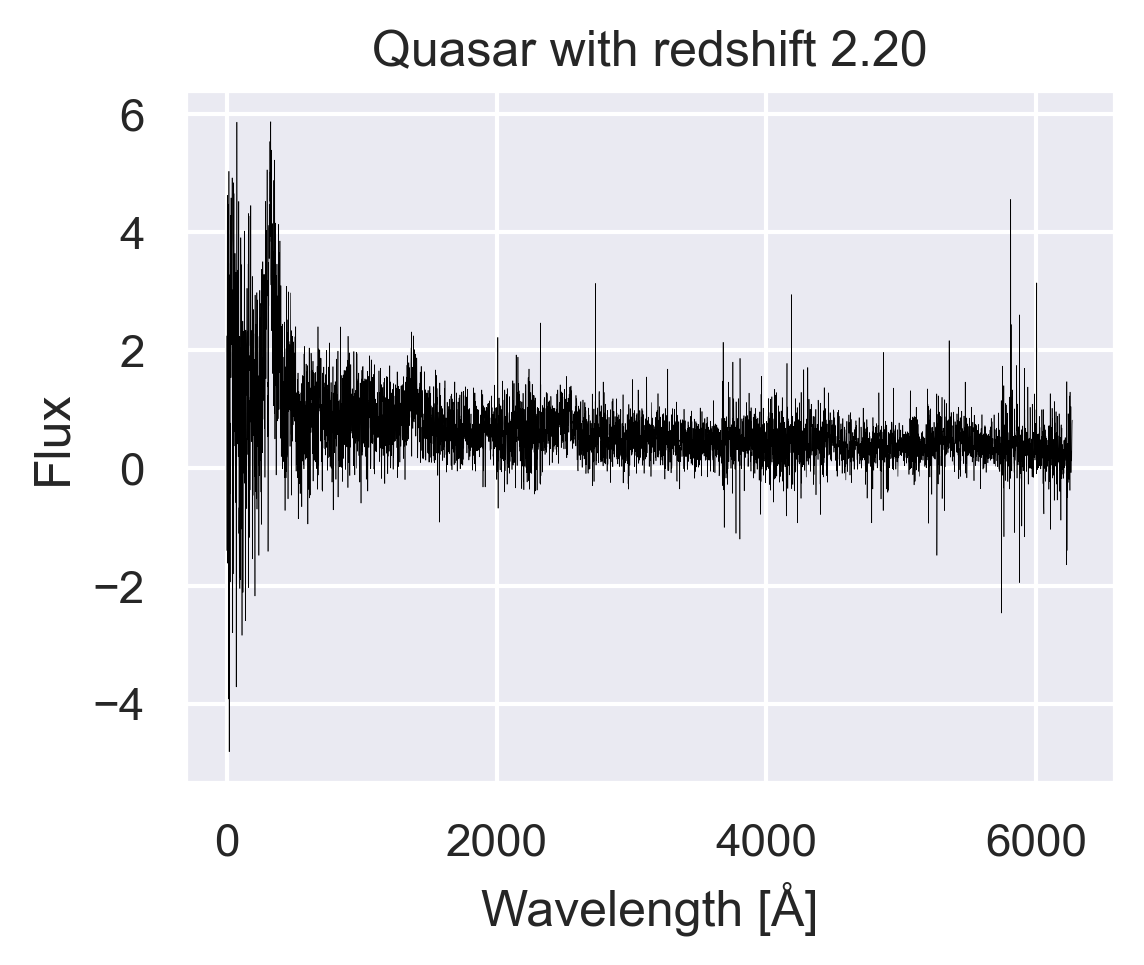

In [42]:
print(f'Shape of quasar: {quasar.shape}')
print(f'Size of dataset: {len(dataset)}')

# Create figure
fig = plt.figure(figsize=(4, 3))

# Example
quasar, label = dataset[5]

plt.plot(quasar, linewidth=0.15, color = 'black')
plt.title(f'Quasar with redshift {label:.2f}')
plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux')
plt.show()

Same with the resampled dataset:

Shape of quasar: (6267,)
Size of dataset: 40000


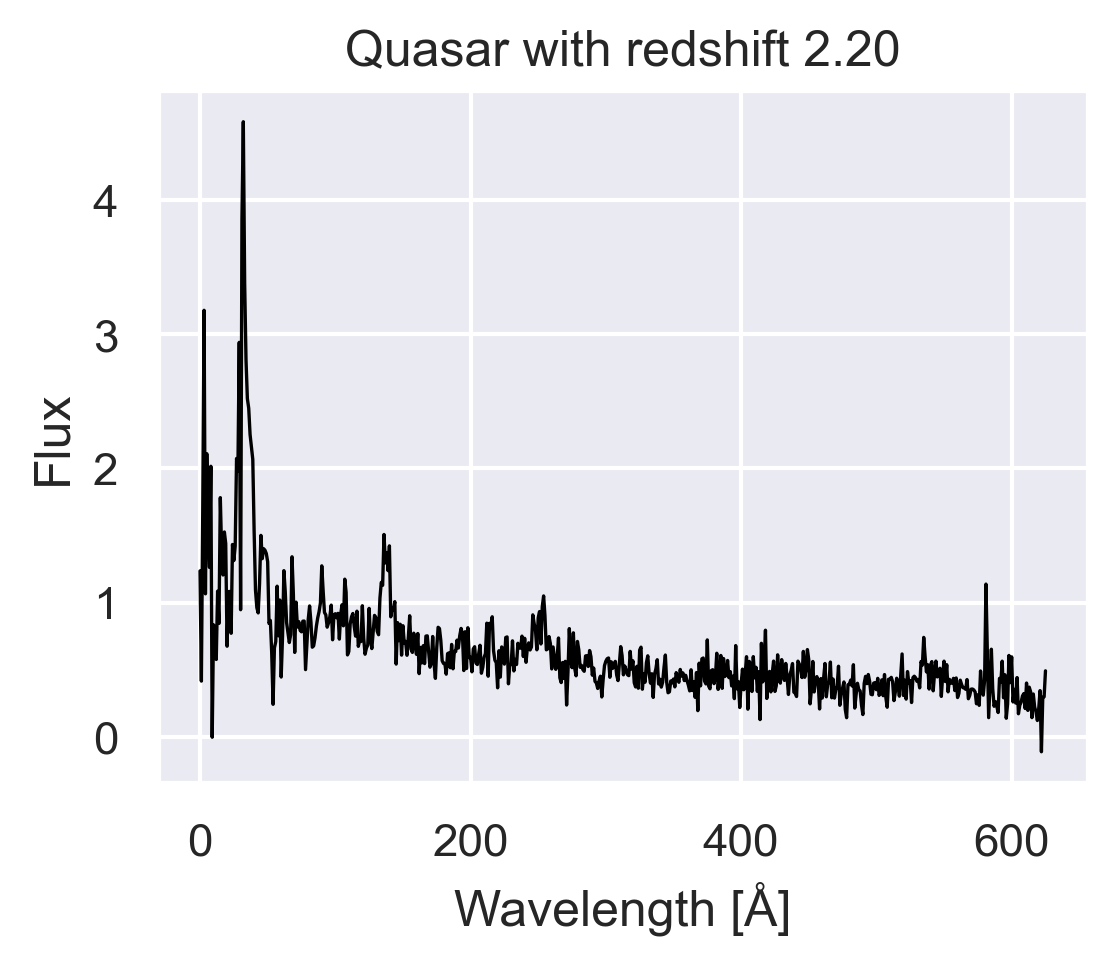

In [43]:
print(f'Shape of quasar: {quasar.shape}')
print(f'Size of dataset: {len(dataset)}')

# Create figure
fig = plt.figure(figsize=(4, 3))

# Example
quasar, label = dataset_rebinned[5]

plt.plot(quasar, color = 'black', linewidth = 0.8)
plt.title(f'Quasar with redshift {label:.2f}')
plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux')
plt.show()

## Report plots 📊



Befor start creating and training models, we need an intelligent way to compare the results. For that, we created a function that takes the predicted and real redshifts, the training and validation losses, the model metrics, and the hyperparameters used. This function generates a report with the results, and saves it in a file. This function is shown below:

In [23]:
def report_plot(labels, predictions, train_losses, val_losses, config, metrics_values):
    """Plot model details, performance and losses.

    Parameters
    ----------
    labels : array
        Array of labels (redshifts).
    predictions : array
        Array of predictions (redshifts).
    train_losses : array
        Array of train losses.
    val_losses : array
        Array of validation losses.
    config : dict
        Dictionary with model configuration.
    metrics_values : dict
        Dictionary with model metrics.

    Returns
    -------
    None
    """
    # Create figure
    fig = plt.figure(constrained_layout = True, figsize=(8, 11))

    # Create subfigures for different plots
    subfigs = fig.subfigures(4, 1, wspace=0.05, hspace=0.01,
        width_ratios=[1], height_ratios=[0.6, 1.5, 1, 1.5])

    # Set titles
    subfigs[0].suptitle(f'Model details, hyperparemeters and metrics', fontsize=20)
    subfigs[1].suptitle('Model performance', fontsize=16)
    subfigs[2].suptitle('Error distribution', fontsize=16)
    subfigs[3].suptitle('Losses', fontsize=16)

    # write model details
    ax_details = subfigs[0].subplots(1, 1)
    ax_details.axis('off')
    t = (
        f'Model type = {config["model_type"]} - {config["layers_dims"]}\n' + \
        f'Learning rate = {config["learning_rate"]}, epochs = {config["epochs"]}, ' + \
        f'Batch size = {config["batch_size"]}, Dropout = {config["dropout"]}\n' + \
        f'MAE = {metrics_values["mae"]:.6f}, MSE = {metrics_values["mse"]:.6f}, ' + \
        f'CCC = {metrics_values["ccc"]:.6f}, R2 = {metrics_values["r2"]:.6f}'
    ).expandtabs()
    ax_details.text(0.5, 0.5, t, fontsize=13, verticalalignment='center',
                    horizontalalignment='center', wrap = True,
                    bbox=dict(facecolor='#EAEAF2', boxstyle='round', pad=1))

    # Plot performance
    ax_perf = subfigs[1].subplots(1, 2)

    # Plot error distribution
    mean = np.mean(np.abs(labels - predictions))
    std = np.std(np.abs(labels - predictions))
    ax_perf[0].scatter(labels, predictions, s=10, alpha = 0.2, color = 'green')
    ax_perf[0].plot([-1, 6], [-1, 6], color='black', linestyle='--', zorder=10)
    ax_perf[0].set_xlim(min(labels)- 0.1, max(labels) + 0.1)
    ax_perf[0].set_ylim(min(labels)-0.1, max(labels)+0.1)
    ax_perf[0].set_title('Predicted vs. actual redshift')
    ax_perf[0].set_xlabel('Real redshift')
    ax_perf[0].set_ylabel('Predicted redshift')

    idx_sort = np.argsort(labels)

    delta_vel = (labels - predictions)/(1+labels)*300_000
    delta_vel_mean = np.mean(delta_vel)
    delta_vel_std = np.std(delta_vel)

    # 50 bins with 3 std
    bins = np.linspace(-2.5*delta_vel_std, 2.5*delta_vel_std, 50)

    hist = ax_perf[1].hist(delta_vel, bins = bins,
        color = 'blue', alpha = 0.5, label = 'This', density = True,
        histtype = 'stepfilled')
    # Set ylimit with highest bin
    ax_perf[1].set_ylim(0, max(hist[0]))

    # Set xlim to 3 std
    ax_perf[1].set_xlim(-2.5*delta_vel_std, 2.5*delta_vel_std)

    # Plot error distribution from quasarNet
    # mean = 8, std = 664
    aux = np.linspace(-3000,  3000, 1000)
    ax_perf[1].plot(aux, stats.norm.pdf(aux, 8, 664),
        color = 'black', label = 'QuasarNet', linestyle = '--', linewidth = 2)

    ax_perf[1].set_xlabel('$\Delta v$ [km/s]')
    ax_perf[1].set_ylabel('Density')
    ax_perf[1].set_title(f'$\Delta v$ = {delta_vel_mean:.2f}'+ \
        ' $\pm$ {delta_vel_std:.2f} km/s')
    ax_perf[1].legend()

    # Plot error distribution
    ax_err = subfigs[2].subplots(1, 1)

    ax_err.plot(labels[idx_sort] - predictions[idx_sort], linewidth=0.3, color = 'black')
    ax_err.set_ylabel('$\Delta Z$')
    ax_err.set_xlabel('Quasar index')
    ax_err.set_ylim(-1, 1)

    # Plot losses
    ax_loss = subfigs[3].subplots(1, 2)
    ax_loss[1].plot(val_losses, label='Validation loss')
    ax_loss[1].plot(train_losses, label='Train loss')
    ax_loss[1].set_yscale('log')
    ax_loss[1].legend()
    ax_loss[1].set_xlabel('Epoch')
    ax_loss[1].set_ylabel('Loss')

    ax_loss[0].plot(val_losses, label='Validation loss')
    ax_loss[0].plot(train_losses, label='Train loss')
    ax_loss[0].legend()
    ax_loss[0].set_xlabel('Epoch')
    ax_loss[0].set_ylabel('Loss')
    return fig


We can see an example of the report below (with random data and hyperparameters):

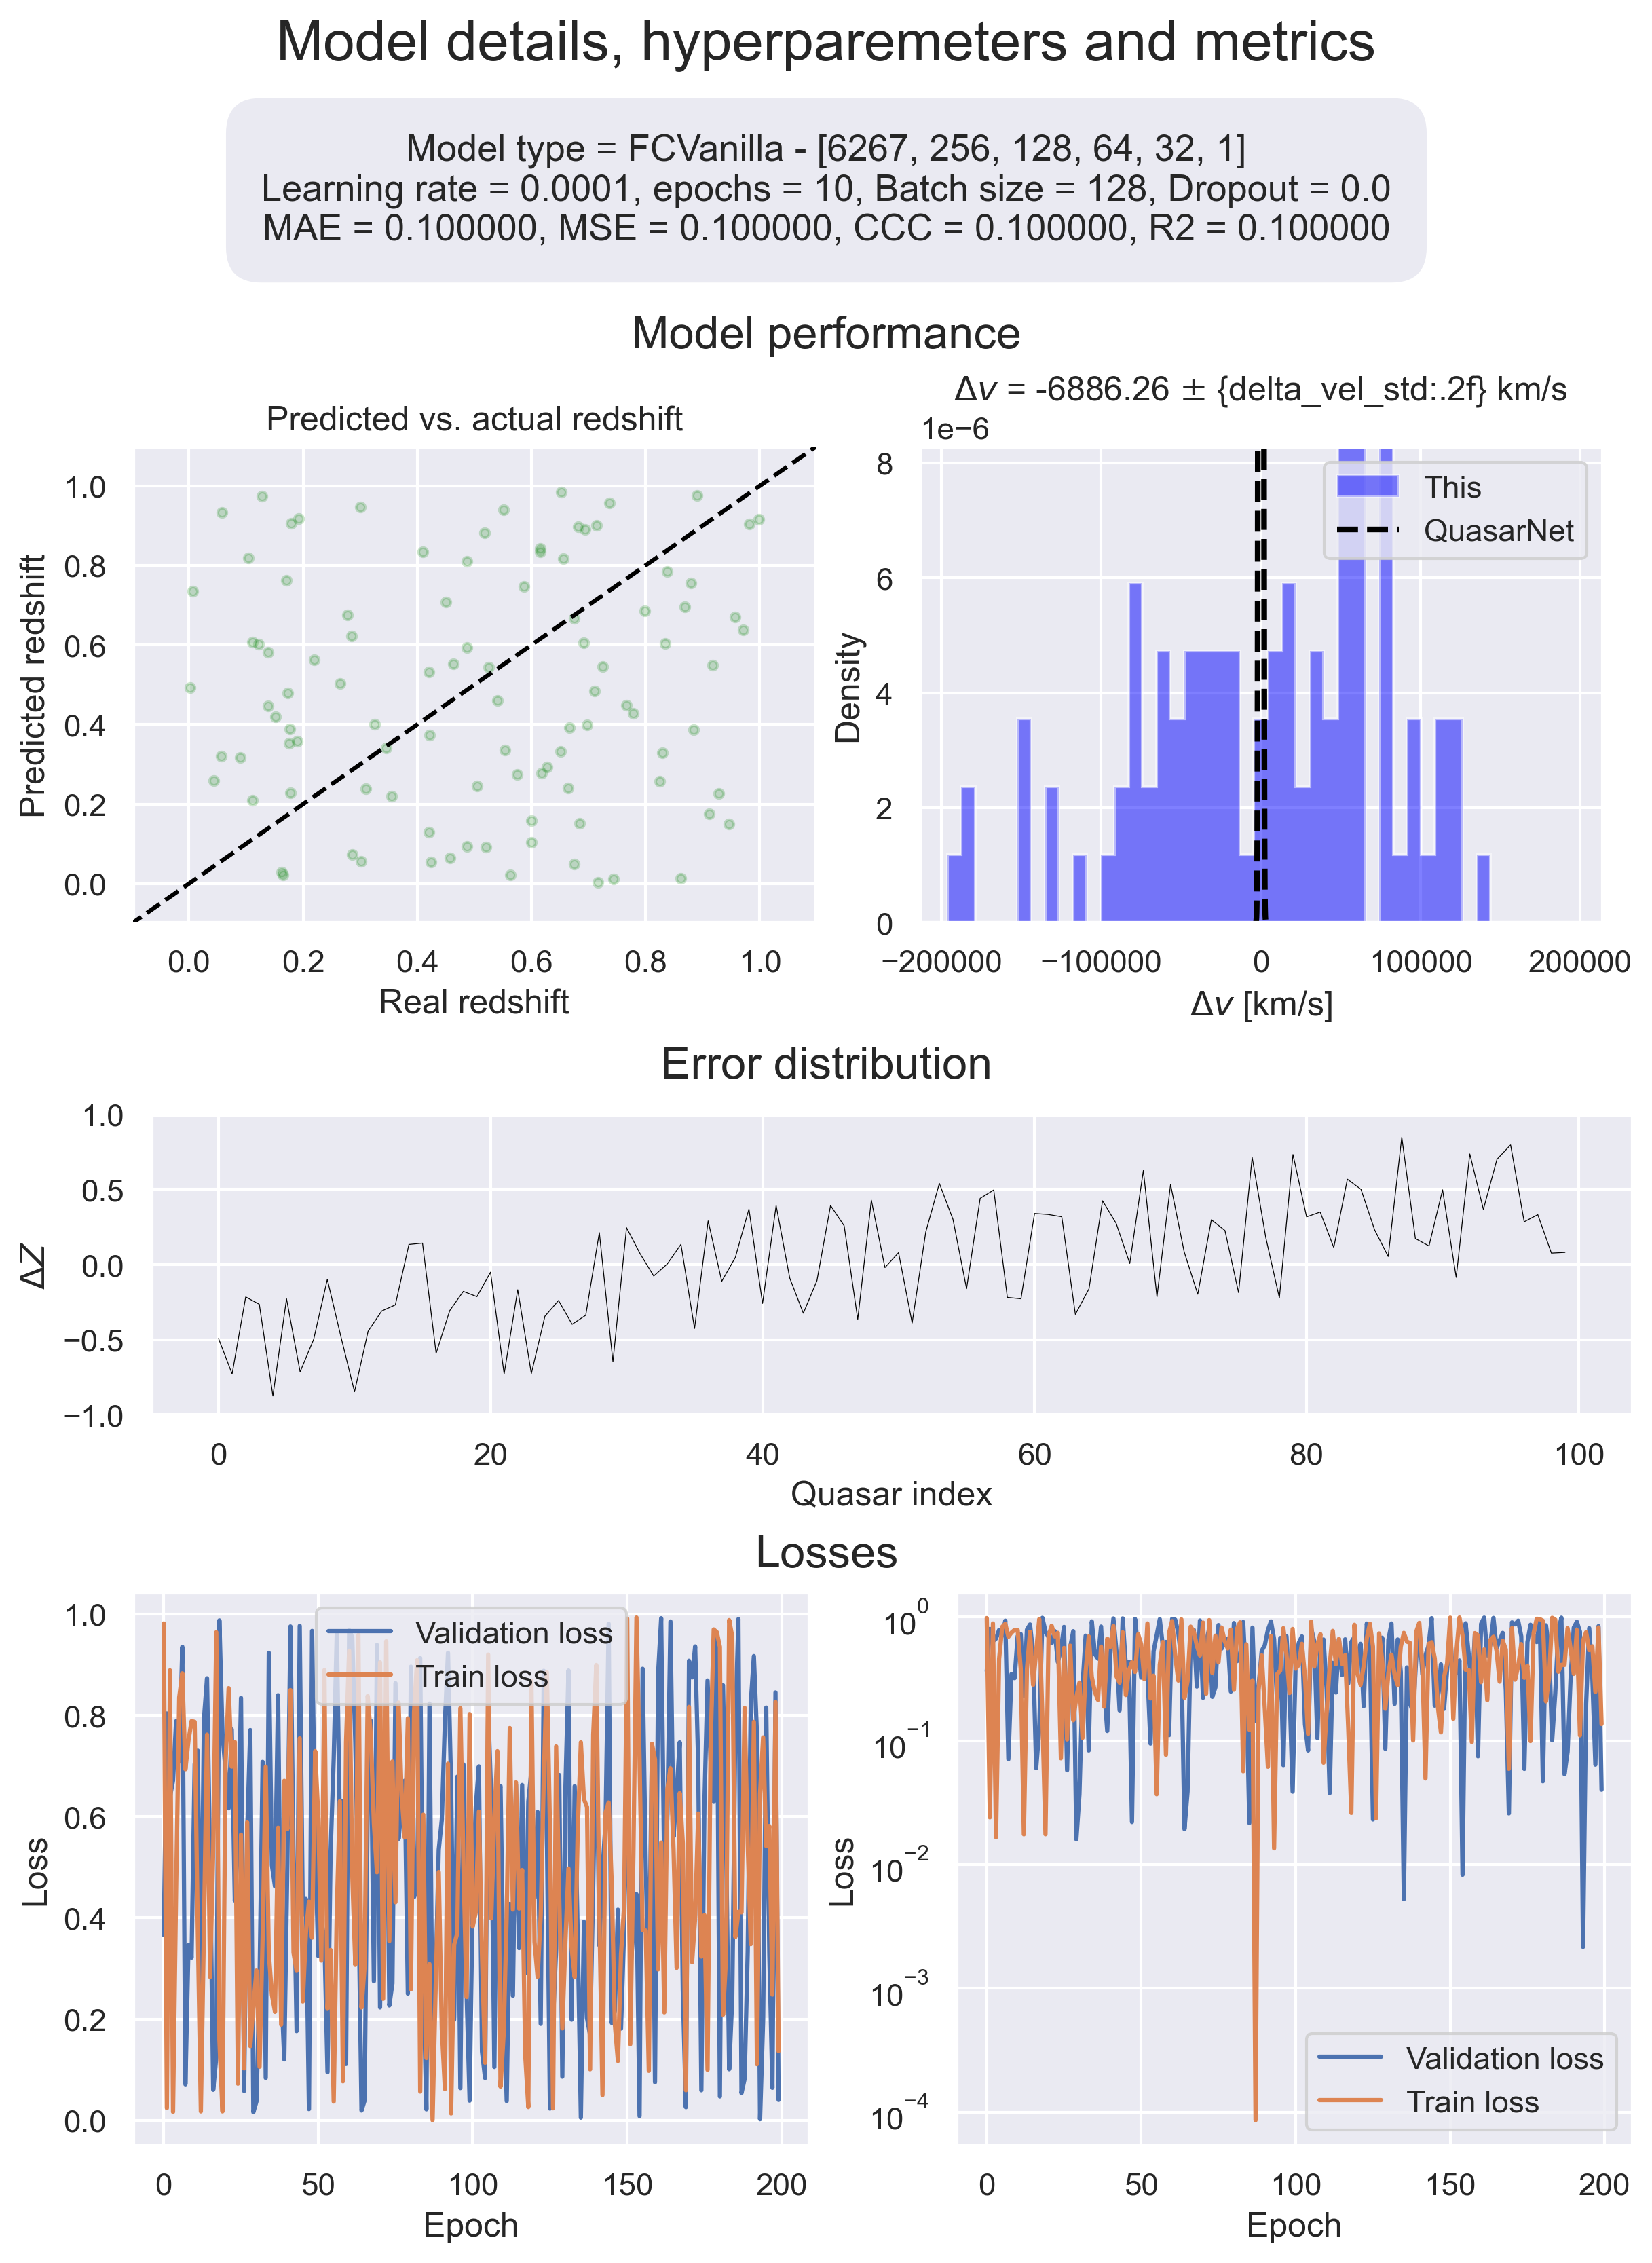

In [24]:
# Random values
labels = np.random.rand(100)
predictions = np.random.rand(100)
val_loss = np.random.rand(200)
train_loss = np.random.rand(200)

config_fc = {
    'epochs': 10,
    'batch_size': 128,
    'learning_rate': 0.0001,
    'dropout': 0.0,
    'model_type': 'FCVanilla',
    'layers_dims': [6267, 256, 128, 64, 32, 1]
}

metrics_values = {
    'mae': 0.1,
    'mse': 0.1,
    'ccc': 0.1,
    'r2': 0.1
}

report = report_plot(labels, predictions, train_loss, val_loss, config_fc, metrics_values)

## Model architectures 🧱

Now, we are going to define the model architectures. We tried two different approaches: a fully connected neural network, and a convolutional neural network. We tried different architectures for each of those approaches, and we obtained the best results with a fully connected neural network.

For the fully connected neural network, we created the FCVanilla class, which inherits from `torch.nn.Module`, and doesn't has dropout layers nor batch normalization. This class recieves a list with layers sizes, and creates a fully connected neural network with those layers. The class is shown below:

In [61]:
class FCVanilla(nn.Module):
    """ Fully connected vanilla model.

    It is a simple fully connected model with ReLU activation function. It doesn't
    have any dropout layer or batch normalization.

    Args:
        layers_dims (list): List of dimensions for each layer

    Returns:
        nn.Module: Fully connected model
    """

    def __init__(self, layers_dims):
        super().__init__()
        self.type = 'FCVanilla'
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential()

        for i in range(len(layers_dims) - 1):
            self.linear_relu_stack.add_module(f'linear_{i}', nn.Linear(layers_dims[i],
                 layers_dims[i+1]))
            self.linear_relu_stack.add_module(f'relu_{i}', nn.ReLU())

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Also, we create the FCBatchNormDropout class, which inherits from `torch.nn.Module`, and has dropout layers and batch normalization. This class recieves a list with layers sizes, and creates a fully connected neural network with those layers. The class is shown below:

In [29]:
class FCBatchNormDropout(nn.Module):
    """ Fully connected model with batch normalization and dropout.

    It is a fully connected model with ReLU activation function, batch normalization
    and dropout.

    Args:
        layers_dims (list): List of dimensions for each layer
        dropout (float): Dropout rate

    Returns:
        nn.Module: Fully connected model
    """
    def __init__(self, layers_dims, dropout=0.5):
        super().__init__()
        self.type = 'FCBatchNormDropout'
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential()

        for i in range(len(layers_dims) - 1):
            self.linear_relu_stack.add_module(f'linear_{i}',
            nn.Linear(layers_dims[i], layers_dims[i+1]))
            self.linear_relu_stack.add_module(f'batchnorm_{i}',
            nn.BatchNorm1d(layers_dims[i+1]))
            self.linear_relu_stack.add_module(f'relu_{i}', nn.ReLU())
            self.linear_relu_stack.add_module(f'dropout_{i}', nn.Dropout(dropout))

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

We can pass both models random data with the same shape as the data we are going to use to see if they work correctly.

In [30]:
# Plumbing all the models
model_fc_vanilla = FCVanilla(layers_dims=[6267, 1024, 256, 64, 16, 1])
model_fc_batchnorm_dropout = FCBatchNormDropout(layers_dims=[6267, 1024,
    256, 64, 16, 1], dropout=0.2)

x = torch.randn(10, 6267, dtype = torch.float32)
try:
    model_fc_vanilla(x)
    model_fc_batchnorm_dropout(x)
except Exception as e:
    print(e)

The output of both models looks like this:

In [37]:
print(model_fc_batchnorm_dropout(x))
print(model_fc_vanilla(x))

tensor([[0.0000],
        [1.0768],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.3208],
        [0.3634],
        [0.0000],
        [2.9242]], grad_fn=<MulBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<ReluBackward0>)


Right now, these numbers are random, but we can see that the output has the correct shape. We can try different architectures for both models, and see which one works better. We will do this in the next section.


Similarly, we create two classes for the convolutional neural network: CNNVanilla and CNNDeep. Both of them inherit from `torch.nn.Module`, and have batch normalization. They sequential blocks composed of a convolutional layer, a batch normalization layer, and a ReLU activation function. The CNNDeep class has more layers than the CNNVanilla class. The classes are shown below:

In [35]:
class CNNVanilla(nn.Module):
    """ CNN vanilla model.

    It is a simple CNN model with ReLU activation function,
    with batch normalization.

    Args:
        None

    Returns:
        nn.Module: CNN model
    """
    def __init__(self):
        super().__init__()
        self.type = 'CNNVanilla'
        self.flatten = nn.Flatten()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv1d(in_channels = 1, out_channels = 16, kernel_size = 9,
            stride = 2, padding = 'valid'),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(in_channels = 16, out_channels = 32, kernel_size = 7,
            stride = 2, padding = 'valid'),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(in_channels = 32, out_channels = 64, kernel_size = 5,
            stride = 1, padding='same'),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(in_channels = 64, out_channels = 128, kernel_size = 3,
            stride = 1, padding='same'),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(4)
        )
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(768, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Add empty channel dimension
        x = x.unsqueeze(1)

        # Reorder the dimensions of the input tensor
        # (channels, batch_size, time_steps) -> (batch_size, channels, time_steps)
        # x = x.permute(0, 2, 1)

        x = self.conv_relu_stack(x)

        x = x.view(x.size(0), -1)
        logits = self.linear_relu_stack(x)
        return logits

class CNNDeep(nn.Module):
    """ CNN deep model.

    It is a deep CNN model with ReLU activation function,
    with batch normalization.

    Args:
        None

    Returns:
        nn.Module: CNN model
    """
    def __init__(self):
        super().__init__()
        self.type = 'CNNDeep'
        self.flatten = nn.Flatten()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv1d(in_channels = 1, out_channels = 16, kernel_size = 9,
            padding = 'same'),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels = 16, out_channels = 32, kernel_size = 7,
            padding = 'same'),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels = 32, out_channels = 64, kernel_size = 5,
            padding = 'same'),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels = 64, out_channels = 128, kernel_size = 5,
            padding = 'same'),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels = 128, out_channels = 192, kernel_size = 3,
            padding = 'same'),
            nn.BatchNorm1d(192),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels = 192, out_channels = 256, kernel_size = 3,
            padding = 'same'),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(in_channels = 256, out_channels = 329, kernel_size = 3,
            padding = 'same'),
            nn.BatchNorm1d(329),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(in_channels = 329, out_channels = 393, kernel_size = 3,
            padding = 'same'),
            nn.BatchNorm1d(393),
            nn.ReLU(),
            nn.MaxPool1d(4),
        )
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1179, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Add empty channel dimension
        x = x.unsqueeze(1)

        # Reorder the dimensions of the input tensor
        # (channels, batch_size, time_steps) -> (batch_size, channels, time_steps)
        # x = x.permute(0, 2, 1)

        x = self.conv_relu_stack(x)

        x = x.view(x.size(0), -1)
        logits = self.linear_relu_stack(x)
        return logits

It's important to note that these models are predefined. However, prior to defining them, we tried different architectures, and we obtained bad restults with all of them. The better results were obtained with the models defined above, and we decided to use them for the final report. The results of both models are still pretty bad, reaching only $MAE \approx 1.5$.

This may be because different reasons: not enough data, an undetected bug in the code, or trying bad architectures in all the differente approaches tried.

We can see that both convolutional models work correctly, and the output has the correct shape.

In [36]:
# Ploombing the models with random data
x = torch.randn(10, 6267, dtype = torch.float32)

model_cnn_vanilla = CNNVanilla()
model_cnn_deep = CNNDeep()

try:
    model_cnn_vanilla(x)
    model_cnn_deep(x)
    print("Success!")
except Exception as e:
    print(e)

Success!


In [38]:
print(model_cnn_vanilla(x))
print(model_cnn_deep(x))

tensor([[0.5651],
        [0.4215],
        [0.4472],
        [0.4416],
        [0.5056],
        [0.6281],
        [0.5238],
        [0.5950],
        [0.5106],
        [0.5840]], grad_fn=<SigmoidBackward0>)
tensor([[0.5073],
        [0.6894],
        [0.6902],
        [0.6387],
        [0.6294],
        [0.4834],
        [0.6040],
        [0.5303],
        [0.5351],
        [0.5824]], grad_fn=<SigmoidBackward0>)


The model architerctures are shown below:

In [39]:
print(model_cnn_vanilla)

CNNVanilla(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_relu_stack): Sequential(
    (0): Conv1d(1, 16, kernel_size=(9,), stride=(2,), padding=valid)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(16, 32, kernel_size=(7,), stride=(2,), padding=valid)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=same)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=same)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=Tr

In [40]:
print(model_cnn_vanilla)

CNNVanilla(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_relu_stack): Sequential(
    (0): Conv1d(1, 16, kernel_size=(9,), stride=(2,), padding=valid)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(16, 32, kernel_size=(7,), stride=(2,), padding=valid)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=same)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=same)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=Tr

## Training and hyperparameter tuning 🏋️

Now we are all set to train our models. We are going to use the Adam optimizer, and the Mean Absolute Error loss function. We are going to train the models with different hyperparameters, and see which one works better. Namely, we are going to train the models with different learning rates, batch sizes, number of epochs, and number of layers.

All the metrics, losses, hyperparameters, and the result figure are uploaded to the Weights & Biases platform. Weights & Biases is a platform for tracking machine learning experiments. It allows to track the metrics, losses, hyperparameters, and the result figure of each experiment. It also allows to compare the results of different experiments, and to see the evolution of the metrics and losses during training. Weights & Biases is free for open source projects, and it's very easy to use. We highly recommend it.

First of all, we need to define a general training function. This function takes the model, the optimizer, the loss function, the training and validation datasets, the number of epochs, and the batch size. This function trains the model, and returns the training and validation losses, and the model metrics. The function is shown below:

In [49]:
def train(model, train_loader, val_loader, loss_fn, optimizer, epochs):
    """ Train the model.

    Args:
        model (nn.Module): model to train
        train_loader (DataLoader): train data loader
        val_loader (DataLoader): validation data loader
        loss_fn (nn.Module): loss function
        optimizer (torch.optim): optimizer
        epochs (int): number of epochs

    Returns:
        train_losses (list): list of train losses
        val_losses (list): list of validation losses
    """
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(epochs)):
        train_loss = 0
        val_loss = 0
        model.train()
        for batch in train_loader:
            # Get data
            quasar, label = batch
            quasar = quasar.type(torch.Tensor).to(device)
            label = label.type(torch.Tensor).to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            pred = model(quasar)
            loss = loss_fn(pred.flatten(), label)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Update loss
            train_loss += loss.item()

        # Validation
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                # Get data
                quasar, label = batch
                quasar = quasar.type(torch.Tensor).to(device)
                label = label.type(torch.Tensor).to(device)

                # Forward pass
                pred = model(quasar)
                loss = loss_fn(pred.flatten(), label)

                # Update loss
                val_loss += loss.item()

        # Update losses
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Log metrics
        wandb.log({'train_loss': train_loss, 'val_loss': val_loss})

    return train_losses, val_losses

We also need a function to evaluate the model. This function takes the model and the validation dataset loader, and returns the model metrics. The function is shown below:

In [50]:
# Get predictions
def get_predictions(model, loader):
    """ Get predictions and metrics for the model.

    Args:
        model (nn.Module): model to evaluate
        loader (DataLoader): data loader (test or validation)

    Returns:
        quasars (list): list of quasars
        labels (list): list of labels
        predictions (list): list of predictions
        metrics_values (dict): dictionary of metrics values
    """
    model.eval()
    quasars = []
    labels = []
    predictions = []
    metrics_values = {}
    with torch.no_grad():
        for batch in loader:
            # Get data
            quasar, label = batch
            quasar = quasar.type(torch.Tensor).to(device)
            label = label.type(torch.Tensor).to(device)

            # Forward pass
            pred = model(quasar)

            # Update lists
            for i in range(len(quasar)):
                quasars.append(quasar[i].cpu().numpy())
                labels.append(float(label[i].cpu().numpy()))
                predictions.append(float(pred[i].cpu().numpy()))
    labels = np.array(labels)
    predictions = np.array(predictions)
    metrics_values = {
        'mae': metrics['mae'](torch.from_numpy(labels), torch.from_numpy(predictions)),
        'mse': metrics['mse'](torch.from_numpy(labels), torch.from_numpy(predictions)),
        'ccc': metrics['ccc'](torch.from_numpy(labels), torch.from_numpy(predictions)),
        'r2': metrics['r2'](torch.from_numpy(labels), torch.from_numpy(predictions))
    }
    return quasars, labels, predictions, metrics_values

Finally, we define a function that creates the data loaders, trains the model, and evaluates it, while uploading the results to Weights & Biases. The function is shown below:

In [51]:
def model_try(config, model, train_set, val_set):
    """ Try a model with the given configuration.

    Args:
        config (dict): configuration
        model (nn.Module): model to train
        train_set (QuasarDataset): train dataset
        val_set (QuasarDataset): validation dataset

    Returns:
        None
    """

    wandb.init(project='QuasarNN', entity = 'gmissaelbarco', config=config)

    epochs = config['epochs']
    batch_size = config['batch_size']
    learning_rate = config['learning_rate']
    dropout = config['dropout']
    model_type = config['model_type']
    layers_dims = config['layers_dims']

    # Create dataloaders
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

    # Create optimize and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.L1Loss()

    # Send model to device
    model.to(device)

    # Train model
    model.train()
    train_losses, val_losses = train(model, train_loader, val_loader, loss_fn,
    optimizer, epochs)

    # Get predictions
    model.eval()
    quasars, labels, predictions, metrics_values = get_predictions(model, val_loader)

    # Send metrics to wandb
    wandb.run.summary['mae'] = metrics_values['mae']
    wandb.run.summary['mse'] = metrics_values['mse']
    wandb.run.summary['ccc'] = metrics_values['ccc']
    wandb.run.summary['r2'] = metrics_values['r2']

    # Save model architecture in wandb
    wandb.save('model.pt')

    # Report plot
    report = report_plot(labels, predictions, train_losses, val_losses, config,
    metrics_values)

    # Send report to wandb
    wandb.log({"Report": wandb.Image(report)})

    # Save report figure
    # If model_type directory does not exist, create it
    if not os.path.exists('reports/'+model_type):
        os.makedirs('reports/'+model_type)
        max_index = 1
    else:
        max_index = max([int(file.split('.')[0]) \
            for file in os.listdir('reports/'+model_type)]) + 1

    # Save figure
    report.savefig(os.path.join('reports/'+ model_type, str(max_index) + '.png'))

    # Save file name in wandb
    wandb.run.summary['report_path'] = \
        str(os.path.join(model_type, str(max_index) + '.png'))

    # Finish run
    wandb.finish()

    # Clear GPU memory
    torch.cuda.empty_cache()

    del model, optimizer, loss_fn, train_loader, val_loader,
    del quasars, metrics_values, labels, predictions, train_losses, val_losses


Now we can try the models with different configurations while keeping track of everything. This is greate because we can compare the results of different experiments, and see which one works better. Also, training a great model is an iterative process, and Weights & Biases allows to see the evolution of the metrics and losses during training.

From this part of the notebook, we are not going to display all of the different experiments we tried. We are going only to show how to run an experiment, and how to do a grid search. This with the four models we defined above. We are going to use the original dataset, and the resampled dataset.

All the experiments restults and hyperparameters are available in the Weights & Biases platform. For this project, we ran more than 70 experiments.

An example for running a unique experiment is shown below:

100%|██████████| 10/10 [00:20<00:00,  2.09s/it]


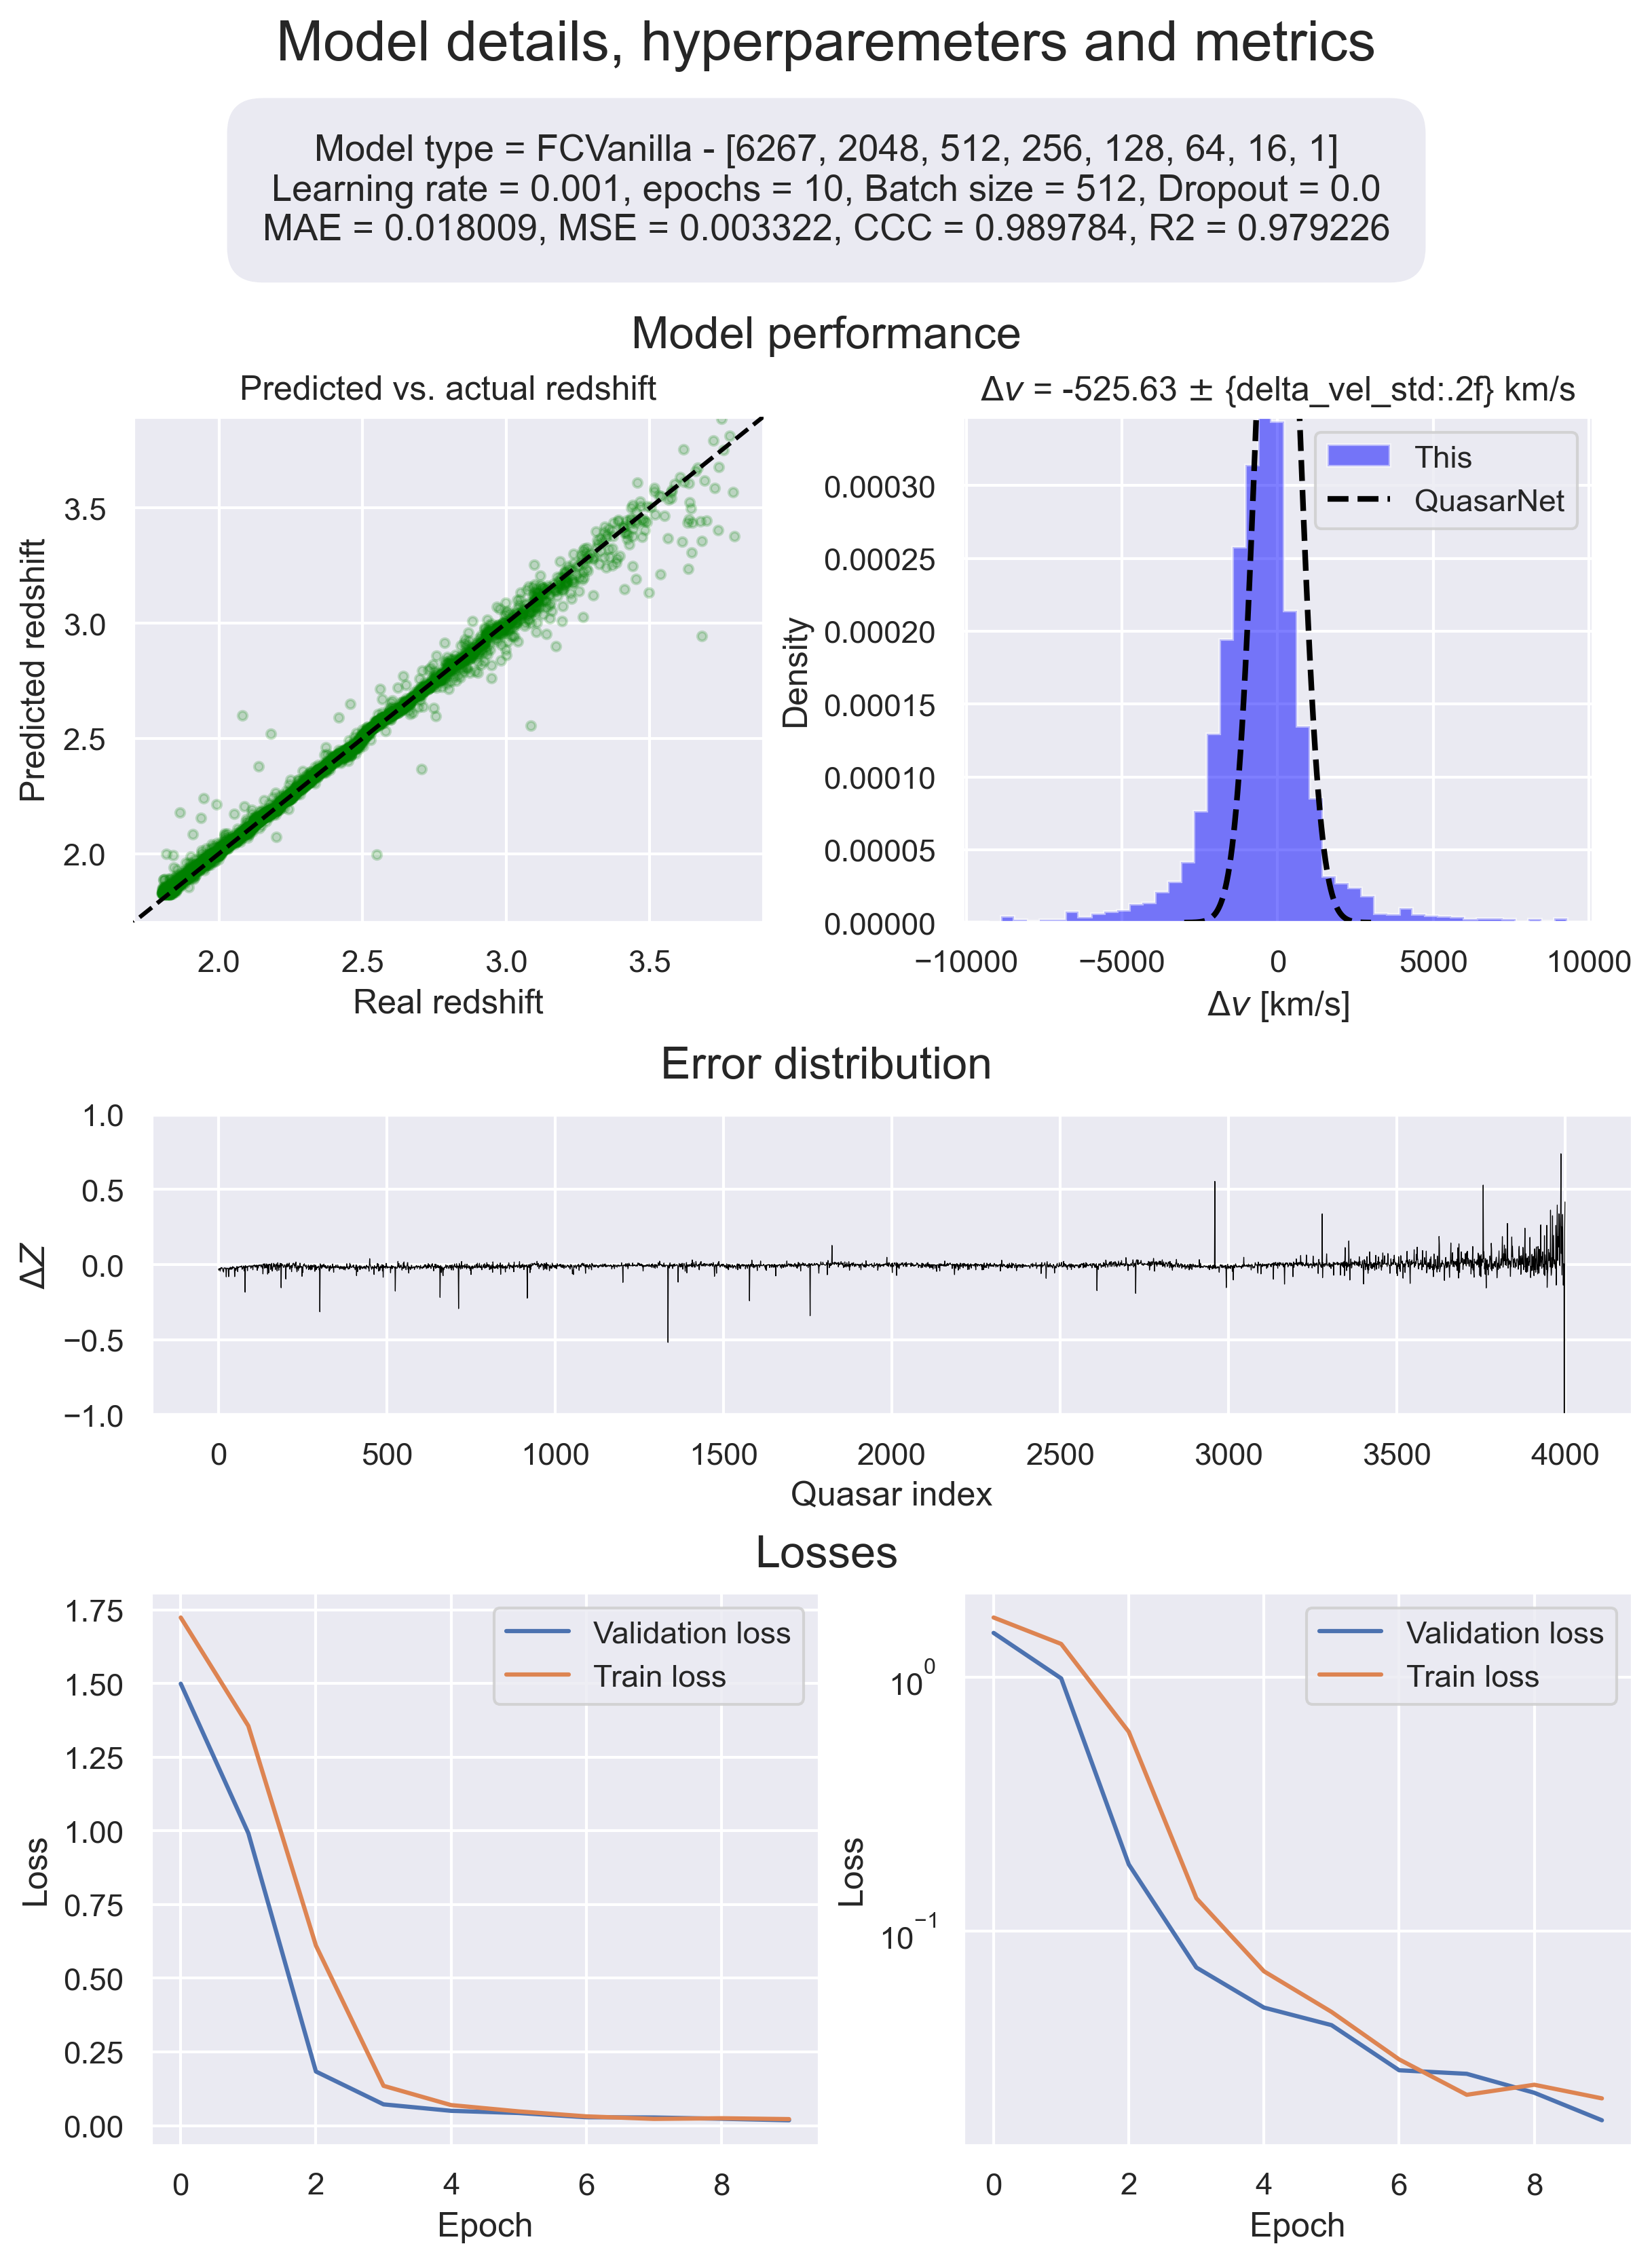

In [57]:
config_fc = {
    'epochs': 10,
    'batch_size': 512,
    'learning_rate': 0.001,
    'dropout': 0.0,
    'model_type': 'FCVanilla',
    'layers_dims': [6267, 2048, 512, 256, 128, 64, 16, 1]
}

# Create model with seed
torch.manual_seed(42)
model = FCVanilla(config_fc['layers_dims'])
model_try(config_fc, model, train_set, val_set)

You can change the model hyperparemeters or architecture, and run the experiment again:

100%|██████████| 20/20 [00:55<00:00,  2.78s/it]


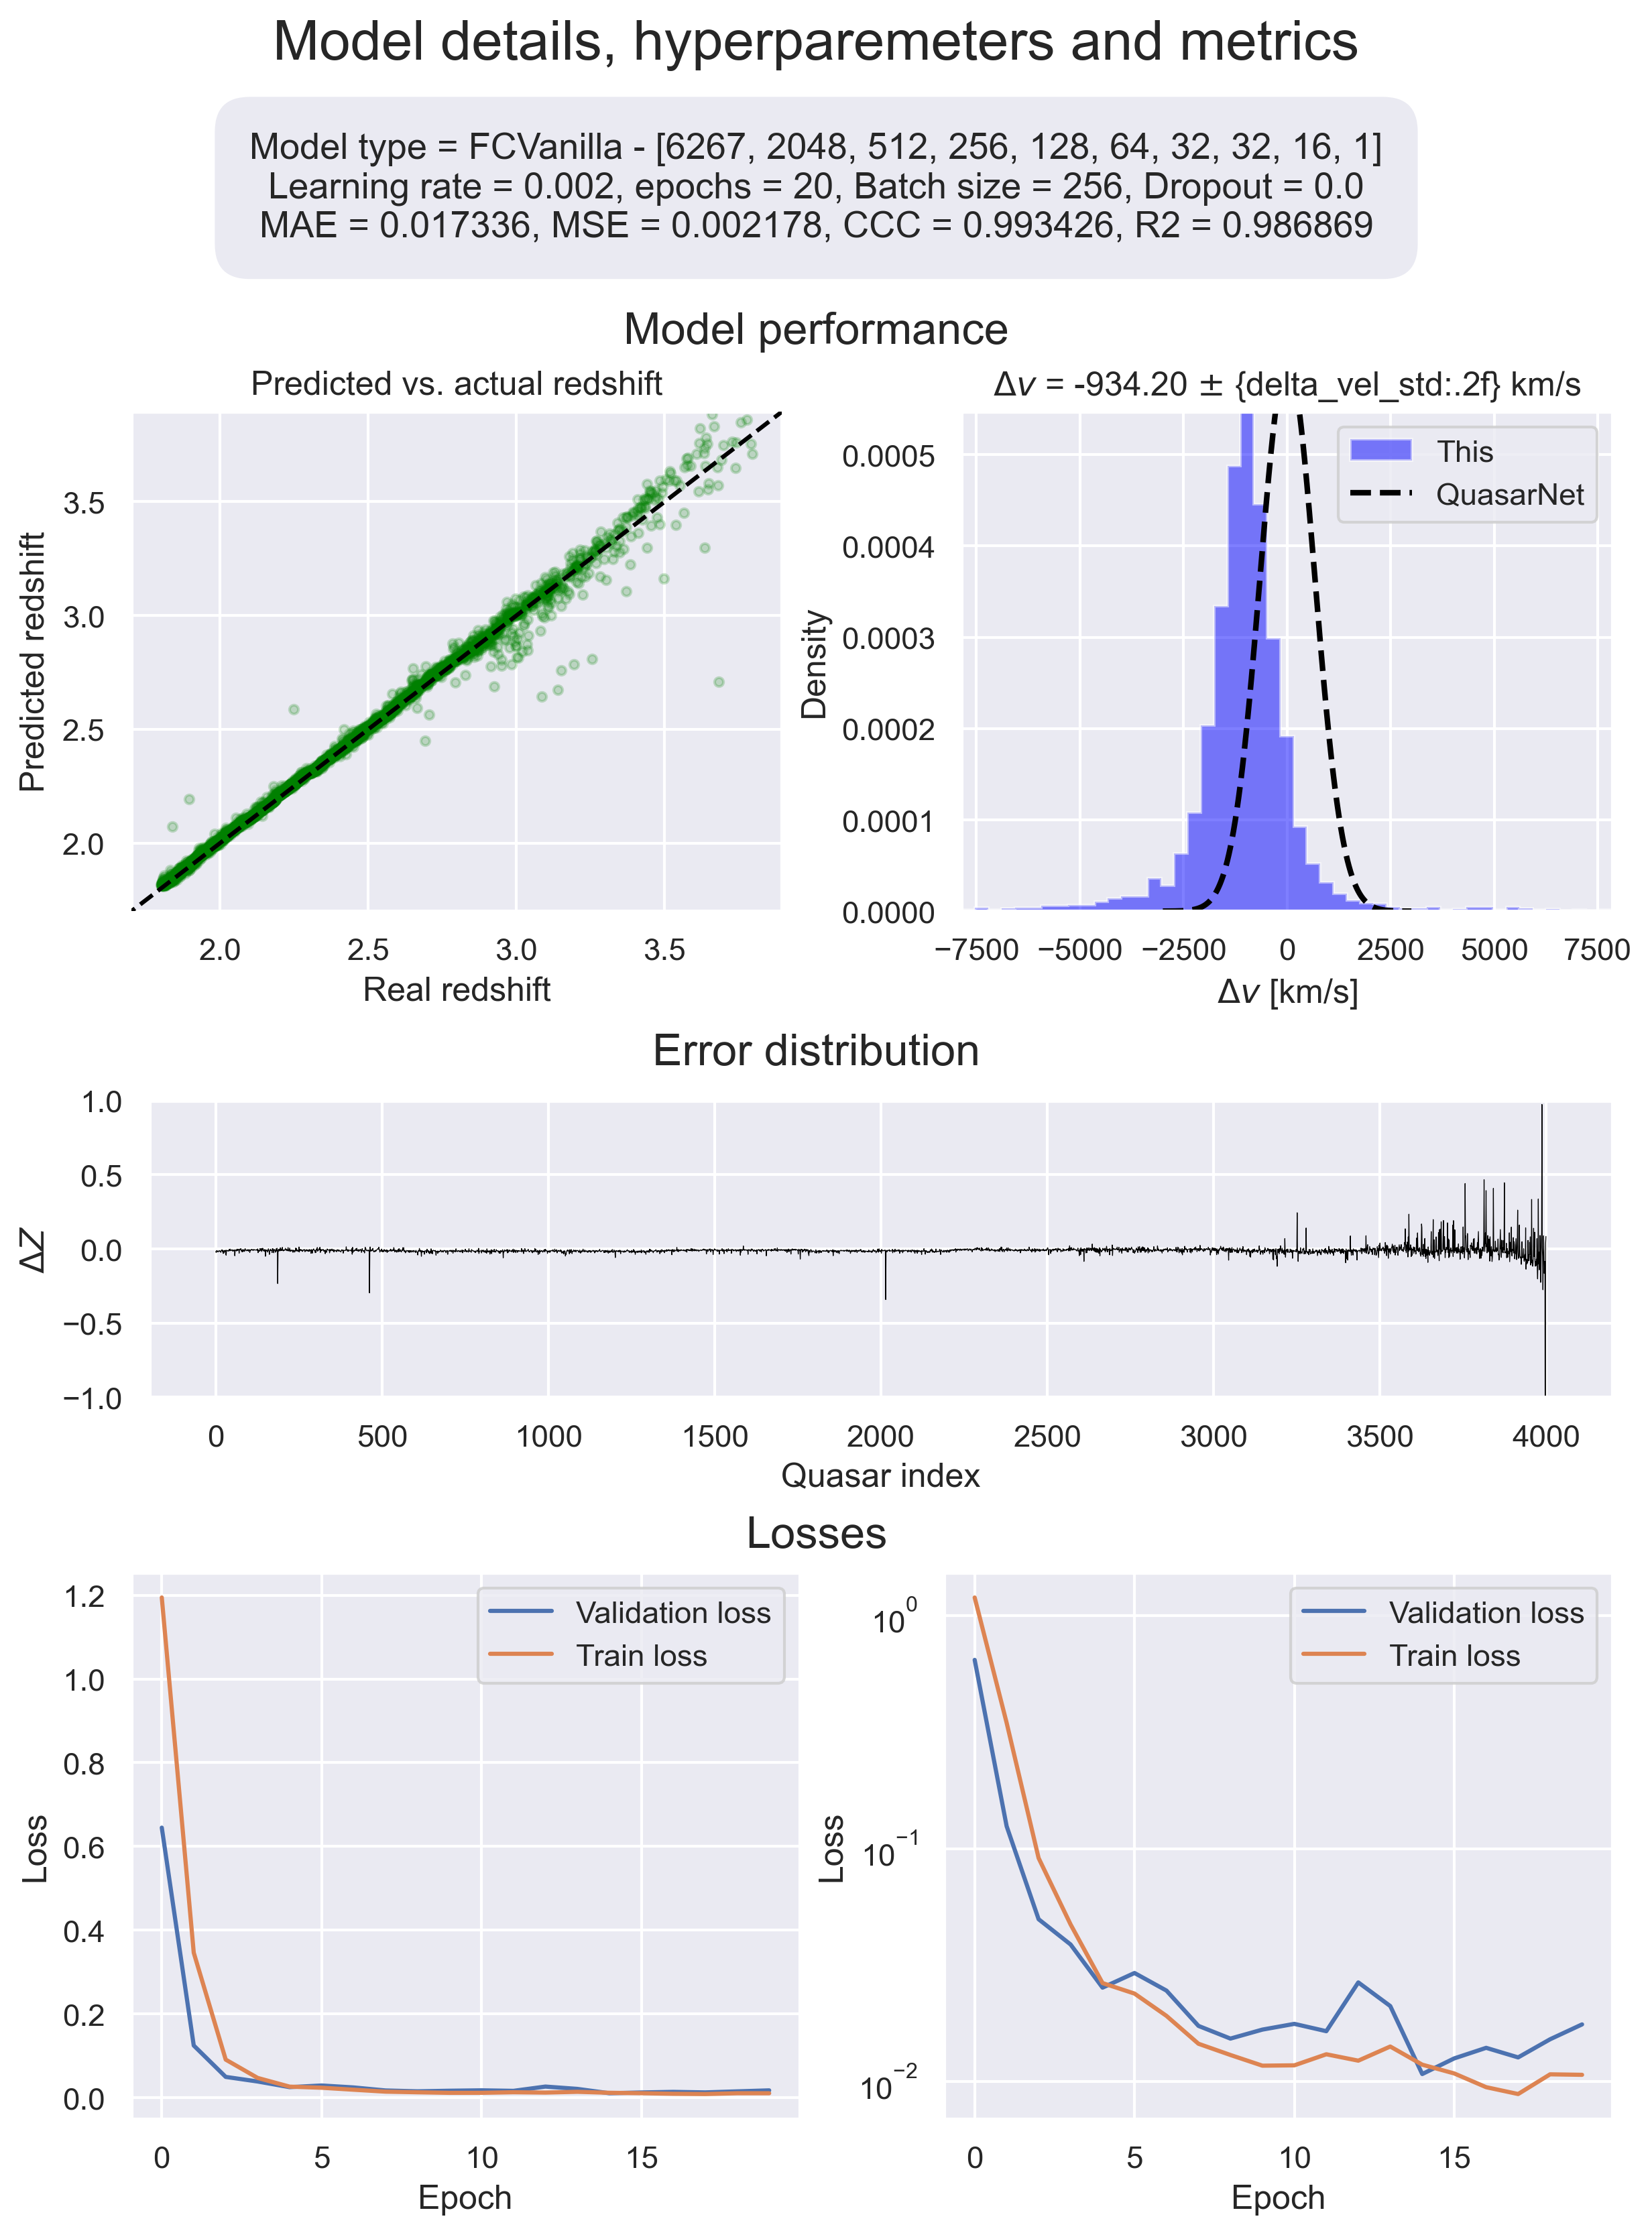

In [60]:
config_fc = {
    'epochs': 20,
    'batch_size': 256,
    'learning_rate': 0.002,
    'dropout': 0.0,
    'model_type': 'FCVanilla',
    'layers_dims': [6267, 2048, 512, 256, 128, 64, 32, 32, 16, 1]
}

# Create model with seed
torch.manual_seed(42)
model = FCVanilla(config_fc['layers_dims'])
model_try(config_fc, model, train_set, val_set)

Finally, we can create some nested loops to do a grid search. The code for a grid search we did in this project in the FCVanilla model is shown below:

In [ ]:
# 36 Modelos diferentes!
possible_epochs = [50]
possible_batch_sizes = [64, 128, 256]
possible_learning_rates = [0.001, 0.0005, 0.0001]
possible_layers_dims = [
    [6267,4096,2048,1024,512,256,128,64,32,1],
    [6267,4096,2048,1024,512,256,128,64,64,64,64,64,64,64,64,64,64,64,32,1],
    [6267,4096,2048,1024,512,256,128,64,32,32,32,32,32,32,32,32,32,32,16,1],
    [6267,4096,2048,2048,1024,1024,512,512,512,256,
    256,256,128,128,128,128,64,64,64,64,32,32,32,32,1],
]

for epochs in possible_epochs:
    for batch_size in possible_batch_sizes:
        for learning_rate in possible_learning_rates:
            for layers_dims in possible_layers_dims:
                config_fc = {
                    'epochs': epochs,
                    'batch_size': batch_size,
                    'learning_rate': learning_rate,
                    'dropout': 0.0,
                    'model_type': 'FCVanilla',
                    'layers_dims': layers_dims
                }

                # Create model with seed
                torch.manual_seed(42)
                model = FCVanilla(config_fc['layers_dims'])
                model_try(config_fc, model, train_set, val_set)

Finally, we did some tests with the resampled dataset, with the FC model with batch normalization and dropout, and the CNNDeep model. We were not able to obtain good results with any of these options. The code to run examples of these experiments is shown in the next sections.

### Try in rebin data

In [ ]:
config_fc = {
    'epochs': 60,
    'batch_size': 128,
    'learning_rate': 0.0005,
    'dropout': 0.0,
    'model_type': 'FCVanilla_rebin',
    'layers_dims': [6267,4096,2048,1024,512,256,128,64,64,64,64,64,64,64,64,64,64,64,32,1]
}

# Create model with seed
model = FCVanilla(config_fc['layers_dims'])
model_try(config_fc, model, train_set_rebin, val_set_rebin)

### Try with BatchNorm and Dropout (whithout rebin)

In [ ]:
config_fc = {
    'epochs': 60,
    'batch_size': 128,
    'learning_rate': 0.0005,
    'dropout': 0.0,
    'model_type': 'FCBatchNormDropout',
    'layers_dims': [6267,4096,2048,1024,512,256,128,64,64,64,64,64,64,64,64,64,64,64,32,1]
}

# Create model with seed
model = FCBatchNormDropout(config_fc['layers_dims'])
model_try(config_fc, model, train_set, val_set)

### Trye CNNs

In [ ]:
config_fc = {
    'epochs': 20,
    'batch_size': 256,
    'learning_rate': 0.001,
    'dropout': 0.0,
    'model_type': 'CNNDeep',
    'layers_dims': 'Default'
}

model = CNNDeep()
model_try(config_fc, model, train_set_rebin, val_set_rebin)

In [ ]:
config_fc = {
    'epochs': 20,
    'batch_size': 256,
    'learning_rate': 0.001,
    'dropout': 0.0,
    'model_type': 'CNNVanilla',
    'layers_dims': 'Default'
}

model = CNNVanilla()
model_try(config_fc, model, train_set_rebin, val_set_rebin)